# Fannie Mae Single-Family Datasets

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from typing import Union, List, Tuple, Type, Dict
import pandas_datareader.data as web
import seaborn as sns
import pickle

# Models
import xgboost as xgb

# Preprocess model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder, CountEncoder
from imblearn.over_sampling import SMOTENC#, SMOTE
from imblearn.under_sampling import RandomUnderSampler


# Model performance metrics
from sklearn.metrics import (
    recall_score, precision_score, average_precision_score,
    f1_score, precision_recall_curve, roc_auc_score, roc_curve
)

In [566]:
# Explainability
import shap

ModuleNotFoundError: No module named 'shap'

# Load files

In [2]:
DATA_PATH = '../datasets/FannieMae/'
glossary = pd.read_excel(DATA_PATH+'crt-file-layout-and-glossary_0.xlsx')
glossary = glossary[~glossary.isna().all(axis=1)] # Remove nan rows
GLOSSARY_COLS =  glossary['Field Name'].loc[~glossary['Field Name'].isnull()].reset_index(drop=True)

In [36]:
RESULTS_PATH = '../results/'

In [3]:
def load_fanniemae_sf(path: str, 
                      Y: Union[int, list]=None, 
                      Q: Union[int, str]=None, 
                      cols: List[str]=None, 
                     ) -> pd.DataFrame:
    # Files to load
    if isinstance(Y, int):
        Y = [Y]  # Convert single year to list
    if isinstance(Q, int):
        Q = [Q]  # Convert single quarter to list
    files = []
    for year in Y:
        if Q == 'all':
            pattern = os.path.join(path, f"{year}Q*.csv")
            files.extend(glob.glob(pattern))
        else:
            for quarter in Q:
                pattern = os.path.join(path, f"{year}Q{quarter}.csv")
                files.extend(glob.glob(pattern))
    print("Files to load:", files)
    df = pd.concat([pd.read_csv(f, sep='|', names=cols) for f in files], ignore_index=True)

    return df

def replaceXX(df):
    
    # Convert 'XX' to NaN (to use ffill)
    df['delinquency_status'] = pd.to_numeric(df['delinquency_status'], errors='coerce')
    
    # Vectorized forward fill within each loan_id group
    mask = df['delinquency_status'].isna()
    df.sort_values(['loan_identifier', 'time'], inplace=True)  # Ensure correct order per loan_id
    df['delinquency_status'] = df.groupby('loan_identifier')['delinquency_status'].ffill().fillna(0)
    
    # Increment the 'XX' (previously NaN) values by 1
    df.loc[mask, 'delinquency_status'] = df.loc[mask, 'delinquency_status']+1
    df['delinquency_status'] = df['delinquency_status'].astype(int)
    df.sort_values('time', inplace=True) # ----------> Maybe remove this

    return df
    
def preprocess_fanniemae_sf(df: pd.DataFrame, selected_features: List[str]=None):

    # Select Features
    if selected_features is None:
        sf_fields = glossary[~glossary['Single-Family (SF) Loan Performance'].isna()]['Field Name'].to_list()
        df = df[sf_fields].copy()
    else:
        df = df[selected_features].copy()
        
    # Format column names
    df.rename(columns={s:'_'.join(s.strip().lower().split()).replace('-', '_') for s in selected_features}, inplace=True)

    # Time features
    df.insert(1, 'time', pd.to_datetime(df['monthly_reporting_period'], format='%m%Y'))
    df.insert(2, 'year', df.time.dt.year)
    df.drop('monthly_reporting_period', axis=1, inplace=True)

    # Rename columns
    df.rename(columns={
        'current_loan_delinquency_status':'delinquency_status',
        'original_loan_to_value_ratio_(ltv)':'ltv',
        'original_combined_loan_to_value_ratio_(cltv)':'cltv',
        'debt_to_income_(dti)':'dti'
                }, inplace=True)
    
    # Remove loans with delinquency status unknown (XX) and no zero balance code (nan)
    id_zbNaN_deliXX = df.loc[(df.delinquency_status == 'XX') & (df.zero_balance_code.isna())].loan_identifier.unique()
    df.drop(df.loc[df['loan_identifier'].isin(id_zbNaN_deliXX)].index, inplace=True)

    # Replace 'XX' with previous delinquency status + 1
    df = replaceXX(df)

    return df

In [4]:
%%time
df = load_fanniemae_sf(DATA_PATH, Y=2005, Q=1, cols=GLOSSARY_COLS)

Files to load: ['../datasets/FannieMae/2005Q1.csv']


/var/folders/x6/nm550mg94y75s74djxxkq6kw0000gr/T/ipykernel_97072/461911941.py:21: DtypeWarning: Columns (40,101,105) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(f, sep='|', names=cols) for f in files], ignore_index=True)


CPU times: user 51.8 s, sys: 32 s, total: 1min 23s
Wall time: 1min 38s


In [6]:
%%time
df = preprocess_fanniemae_sf(df, selected_features=selected_fields)

CPU times: user 19.5 s, sys: 4.09 s, total: 23.6 s
Wall time: 23.6 s


In [12]:
df.head()

,loan_identifier,time,year,channel,original_interest_rate,current_interest_rate,original_upb,current_actual_upb,original_loan_term,loan_age,...,dti,borrower_credit_score_at_origination,co_borrower_credit_score_at_origination,loan_purpose,property_type,number_of_units,occupancy_status,property_state,delinquency_status,zero_balance_code
4263813,255786094177,2005-01-01,2005,C,5.750,5.750,106000.0,0.0,360,1.0,...,29.0,799.0,NaN,P,SF,1,P,TX,0,NaN
21985364,906210945847,2005-01-01,2005,B,6.250,6.250,35000.0,0.0,360,0.0,...,NaN,699.0,716.0,R,SF,1,I,AL,0,NaN
7370051,370893910142,2005-01-01,2005,R,5.750,5.750,122000.0,0.0,360,0.0,...,48.0,725.0,NaN,R,SF,1,P,MI,0,NaN
2658065,196714859176,2005-01-01,2005,R,6.625,6.625,67000.0,0.0,360,3.0,...,50.0,692.0,668.0,C,CO,1,P,FL,0,NaN
24325078,991048429580,2005-01-01,2005,C,5.750,5.750,150000.0,0.0,360,2.0,...,14.0,756.0,757.0,R,SF,1,P,CA,0,NaN


In [11]:
# %%time
# dfagg05 = pd.read_csv(AGG_PATH+'agg_2005.csv')

## Selection of fields

In [5]:
selected_fields=[
'Loan Identifier',
'Monthly Reporting Period',
'Channel',
'Original Interest Rate',
'Current Interest Rate',
'Original UPB',
'Current Actual UPB',
'Original Loan Term',
'Loan Age',
'Remaining Months To Maturity',
'Original Loan to Value Ratio (LTV)',
'Original Combined Loan to Value Ratio (CLTV)',
'Number of Borrowers',
'Debt-To-Income (DTI)',
'Borrower Credit Score at Origination',
'Co-Borrower Credit Score at Origination',
# 'First Time Home Buyer Indicator',
'Loan Purpose ',
'Property Type',
'Number of Units',
'Occupancy Status',
'Property State',
# 'Metropolitan Statistical Area (MSA)',
# 'Zip Code Short',
# 'Mortgage Insurance Percentage',
# 'Amortization Type',
# 'Prepayment Penalty Indicator',
# 'Interest Only Loan Indicator',
# 'Interest Only First Principal And Interest Payment Date',
# 'Months to Amortization',
'Current Loan Delinquency Status',
'Zero Balance Code',
# 'Zero Balance Effective Date',
# 'UPB at the Time of Removal',
# 'Total Principal Current',
# 'Last Paid Installment Date',
# 'Foreclosure Date',
# 'Special Eligibility Program',
# 'Property Valuation Method ',
# 'High Balance Loan Indicator ',
# 'Borrower Assistance Plan',
# 'Alternative Delinquency Resolution',
# 'Alternative Delinquency  Resolution Count'
]

### Notes

- Check features that are present in 'SF Loan Performance: Enhanced format with the October 2020 Release'
- Features 'Origination Date', 'First Payment Date', 'Maturity Date' has to convert to date
- Double check 'Loan Age' for negative values and nan
- Everything related to or after foreclosure is excluded
- Features related to Covid-19: 'Alternative Delinquency Resolution', 'Alternative Delinquency  Resolution Count'

In [475]:
feature = 'Alternative Delinquency  Resolution Count'

print(feature, '\n')
if feature in df_missing.index:
    print(f'Missing values: {df_missing.loc[feature].freq.round(6)*100:.4f}% missing values.')
else:
    print(f'No missing values.')
print(f'Number of unique values: {df[feature].nunique()}')

Alternative Delinquency  Resolution Count 

Missing values: 99.9240% missing values.
Number of unique values: 2


In [476]:
df[feature].sample(10)

1051490   NaN
1271527   NaN
1871826   NaN
3155123   NaN
2787929   NaN
3146109   NaN
3171525   NaN
1737404   NaN
1254018   NaN
3835307   NaN
Name: Alternative Delinquency  Resolution Count, dtype: float64

In [481]:
df[feature].nunique()

2

In [474]:
df[feature].unique()

array(['7', 'P', 7, 'C', 'D'], dtype=object)

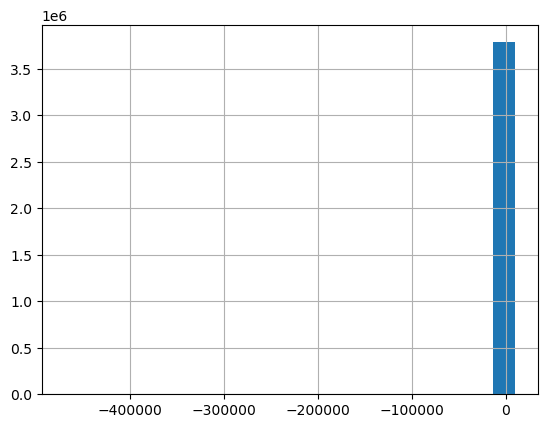

In [450]:
fig, ax = plt.subplots()
df[feature].loc[df[feature] < 1e4].hist(bins=20, ax=ax)
ax.set_xscale('linear')

<Axes: xlabel='Alternative Delinquency Resolution'>

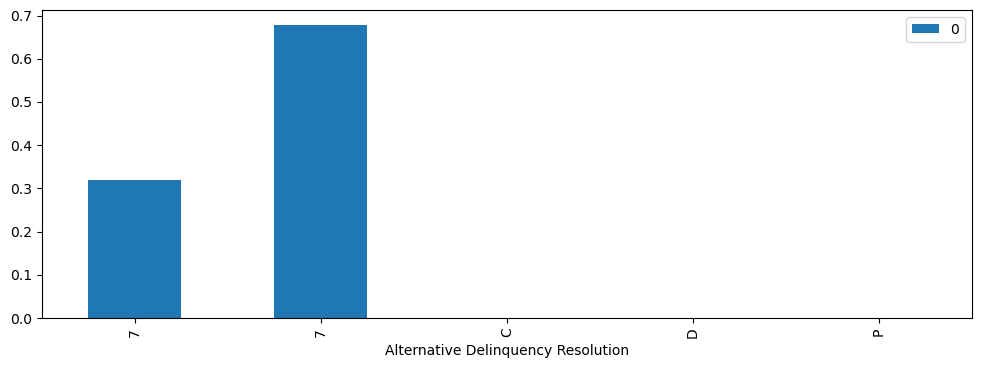

In [473]:
fig, ax = plt.subplots(figsize=(12, 4))
(df.groupby(feature).size().to_frame()/df.shape[0]).plot(kind='bar', ax=ax)

## Missing values

In [519]:
def missing(df):
    missing_values = df.isna().sum()/len(df)
    missing_values = pd.DataFrame(missing_values.loc[missing_values != 0], 
                                  columns=['freq'])#.reset_index(names='Field Name')#.sort_values(by='freq')
    return missing_values

def plot_missing(df_missing, ax=None):
    df_missing.plot(kind='barh', ax=ax)

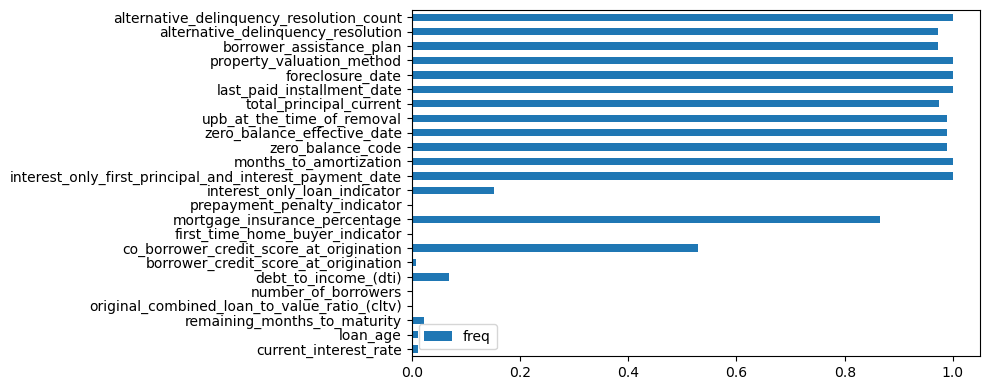

In [520]:
fig, ax = plt.subplots(figsize=(10, 4))

df_missing = missing(df)
plot_missing(df_missing, ax=ax)

plt.tight_layout()
plt.show()

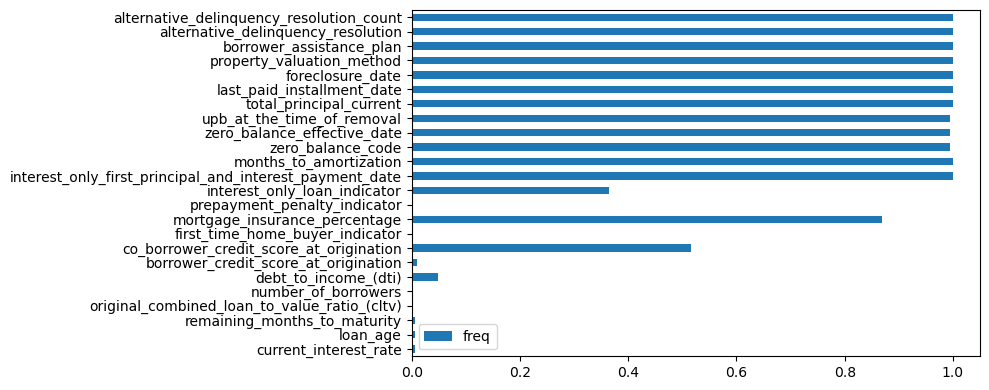

In [17]:
fig, ax = plt.subplots(figsize=(10, 4))

dfagg05_missing = missing(dfagg05)
plot_missing(dfagg05_missing, ax=ax)

plt.tight_layout()
plt.show()

## Agreggate years

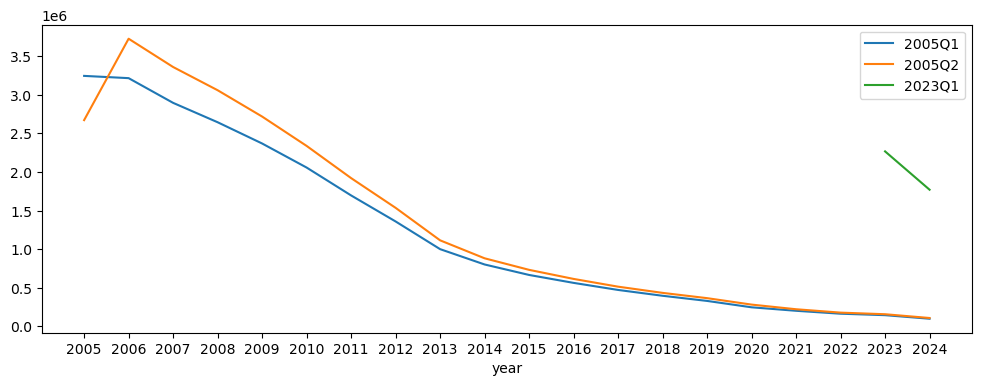

In [785]:
fig, ax = plt.subplots(figsize=(12, 4))

df05.groupby('year')['loan_identifier'].size().plot(ax=ax, label='2005Q1')
df05Q2.groupby('year')['loan_identifier'].size().plot(ax=ax, label='2005Q2')
df23Q1.groupby('year')['loan_identifier'].size().plot(ax=ax, label='2023Q1')

ax.legend()
ax.set_xticks(np.arange(2005, 2025))

plt.show()

### Split years


In [70]:
def split_years(save_path: str, df: pd.DataFrame):
    ''' Split years and save each year in a separate csv file.'''
    for y in df.year.unique():
        print(f'Saving {y}')
        df_year = df.loc[df.year == y]  # Filter year
        # Save path
        file_path = f'{save_path}agg_{y}.csv'
        meta_path = f'{save_path}agg_{y}_meta.csv'
        
        # Check if file exists before reading
        if os.path.exists(file_path):
            df_agg = pd.read_csv(file_path)  # Load existing data
            df_agg = pd.concat([df_agg, df_year], ignore_index=True)  # Append new data
        else:
            df_agg = df_year  # Start a new DataFrame if the file doesn’t exist

        # Save the updated DataFrame
        df_agg.sort_values(by=['time', 'loan_identifier'])
        df_agg.to_csv(file_path, index=False)
        # Meta data
        df_meta = pd.DataFrame(df_agg['acquisition'].unique(), columns=['acquisition'])
        df_meta.to_csv(meta_path, index=False)


In [42]:
def aggregate_fanniemae(input_path: str, 
                        output_path: str, 
                        years: List[int], 
                        quarters: List[int], 
                        cols: pd.Series, 
                        selected_features: List[str]) -> None:
    for y in years:
        if quarters == 'all':
            quarters = [1, 2, 3, 4]
        for q in quarters:
            df = load_fanniemae_sf(input_path, Y=y, Q=q, cols=cols, selected_features=selected_features)
            acq = f'{y}Q{q}'
            df['acquisition'] = acq
            print(f'Splitting {acq}')
            split_years(output_path, df)

In [ ]:
YEAR_LIST = [2005]
QUARTER_LIST = [3]
AGG_PATH = DATA_PATH+'aggregate_years/'

In [ ]:
%%time
aggregate_fanniemae(DATA_PATH, AGG_PATH, YEAR_LIST, QUARTER_LIST, cols=GLOSSARY_COLS, selected_features=selected_fields)

Files to load: ['../datasets/FannieMae/2005Q3.csv']


/var/folders/x6/nm550mg94y75s74djxxkq6kw0000gr/T/ipykernel_64193/4065276026.py:21: DtypeWarning: Columns (40,101,105) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(f, sep='|', names=cols) for f in files], ignore_index=True)


Splitting 2005Q3
Saving 2005
Saving 2006
Saving 2007
Saving 2008
Saving 2009
Saving 2010
Saving 2011
Saving 2012
Saving 2013
Saving 2014
Saving 2015
Saving 2016
Saving 2017
Saving 2018
Saving 2019
Saving 2020
Saving 2021
Saving 2022
Saving 2023
Saving 2024
CPU times: user 16min 26s, sys: 2min 9s, total: 18min 36s
Wall time: 19min 19s


In [45]:
%%time
df2005_12 = pd.read_csv(f'{AGG_PATH}agg_2005.csv')

CPU times: user 6.24 s, sys: 1.24 s, total: 7.49 s
Wall time: 7.51 s


In [57]:
%%time
df2005_123 = pd.read_csv(f'{AGG_PATH}agg_2005.csv')

CPU times: user 8.79 s, sys: 2 s, total: 10.8 s
Wall time: 11 s


In [73]:
%%time
df2005_1234 = pd.read_csv(f'{AGG_PATH}agg_2005.csv')

CPU times: user 9.42 s, sys: 2.26 s, total: 11.7 s
Wall time: 11.9 s


In [51]:
%%time

df2006_12 = pd.read_csv(f'{AGG_PATH}agg_2006.csv')

CPU times: user 7.48 s, sys: 1.56 s, total: 9.04 s
Wall time: 9.13 s


In [78]:
%%time

df2006_1234 = pd.read_csv(f'{AGG_PATH}agg_2006.csv')

CPU times: user 18.1 s, sys: 6.85 s, total: 25 s
Wall time: 27.8 s


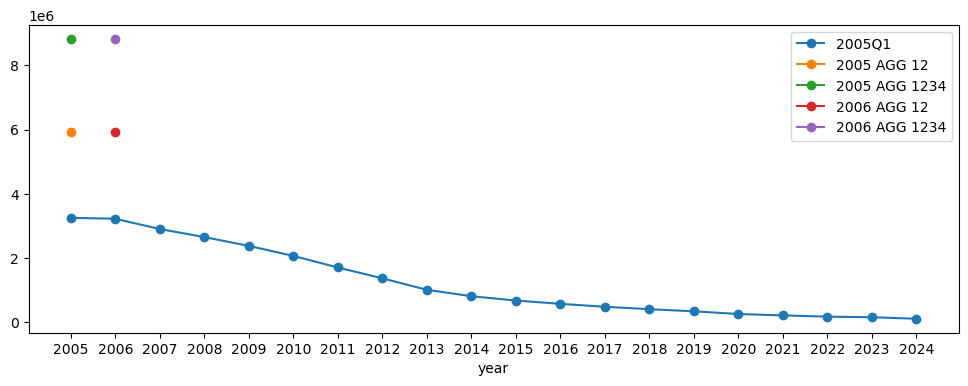

In [80]:
fig, ax = plt.subplots(figsize=(12, 4))

df05Q1.groupby('year')['loan_identifier'].size().plot(ax=ax, marker='o', label='2005Q1')
# df23.groupby('year')['loan_identifier'].size().plot(ax=ax, label='2023Q1')
ax.plot(2005, len(df2005_12), marker='o', label='2005 AGG 12')
ax.plot(2005, len(df2005_1234), marker='o', label='2005 AGG 1234')
ax.plot(2006, len(df2005_12), marker='o', label='2006 AGG 12')
ax.plot(2006, len(df2005_1234), marker='o', label='2006 AGG 1234')

ax.legend()
ax.set_xticks(np.arange(2005, 2025))

plt.show()

# Define fields

In [17]:
selected_variables=[
'loan_identifier',
 'time',
 # 'year',
 'channel',
 'original_interest_rate',
 'current_interest_rate',
 'original_upb',
 'current_actual_upb',
 'original_loan_term',
 'loan_age',
 'remaining_months_to_maturity',
 'original_loan_to_value_ratio_(ltv)',
 'original_combined_loan_to_value_ratio_(cltv)',
 'number_of_borrowers',
 'debt_to_income_(dti)',
 'borrower_credit_score_at_origination',
 'co_borrower_credit_score_at_origination',
 # 'first_time_home_buyer_indicator',
 'loan_purpose',
 'property_type',
 'number_of_units',
 'occupancy_status',
 'property_state',
 # 'metropolitan_statistical_area_(msa)',
 # 'zip_code_short',
 # 'mortgage_insurance_percentage',
 # 'amortization_type',
 # 'prepayment_penalty_indicator',
 # 'interest_only_loan_indicator',
 # 'interest_only_first_principal_and_interest_payment_date',
 # 'months_to_amortization',
 'delinquency_status',
 # 'zero_balance_code',
 # 'zero_balance_effective_date',
 # 'upb_at_the_time_of_removal',
 # 'total_principal_current',
 # 'last_paid_installment_date',
 # 'foreclosure_date',
 # 'special_eligibility_program',
 # 'property_valuation_method',
 # 'high_balance_loan_indicator',
 # 'borrower_assistance_plan', 
 # 'alternative_delinquency_resolution',
 # 'alternative_delinquency_resolution_count',
 'default',
 'pd_target']

In [663]:
feature = 'loan_purpose'

print(feature, '\n')
if feature in df_missing.index:
    print(f'Missing values: {df_missing.loc[feature].freq.round(6)*100:.4f}% missing values.')
else:
    print(f'No missing values.')
print(f'Number of unique values: {df[feature].nunique()}')

loan_purpose 

No missing values.
Number of unique values: 4


In [592]:
df.loc[df[feature].isna()]['loan_identifier'].nunique()/df.loan_identifier.nunique()

2.306067923583498e-05

In [649]:
df.loc[(df[feature].isna())&(df.default == 1)]['loan_identifier'].nunique()/df.loc[df.default == 1]['loan_identifier'].nunique()

0.7701478092556748

In [ ]:
default_loans = list(df.loc[df.default == 1]['loan_identifier'].unique())
nondefault_loans = list(set(df['loan_identifier'].unique()) - set(df.loc[df.default == 1]['loan_identifier'].unique()))

In [624]:
%%time
df_nondefault_first = df.loc[df['loan_identifier'].isin(nondefault_loans)].groupby('loan_identifier').first()
df_default_first = df.loc[df['loan_identifier'].isin(default_loans)].groupby('loan_identifier').first()

CPU times: user 14.9 s, sys: 4.18 s, total: 19 s
Wall time: 21.1 s


In [650]:
df[feature].head()

0    17.0
1     NaN
2     NaN
3     NaN
4     NaN
Name: mortgage_insurance_percentage, dtype: float64

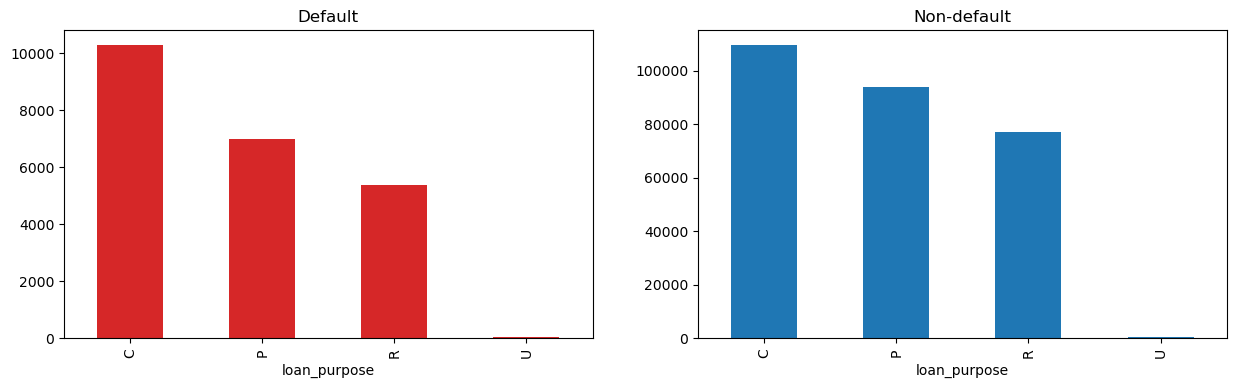

In [664]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

df_default_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[0], color='tab:red')
df_nondefault_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[1])

ax[0].set_title('Default')
ax[1].set_title('Non-default')

plt.show()

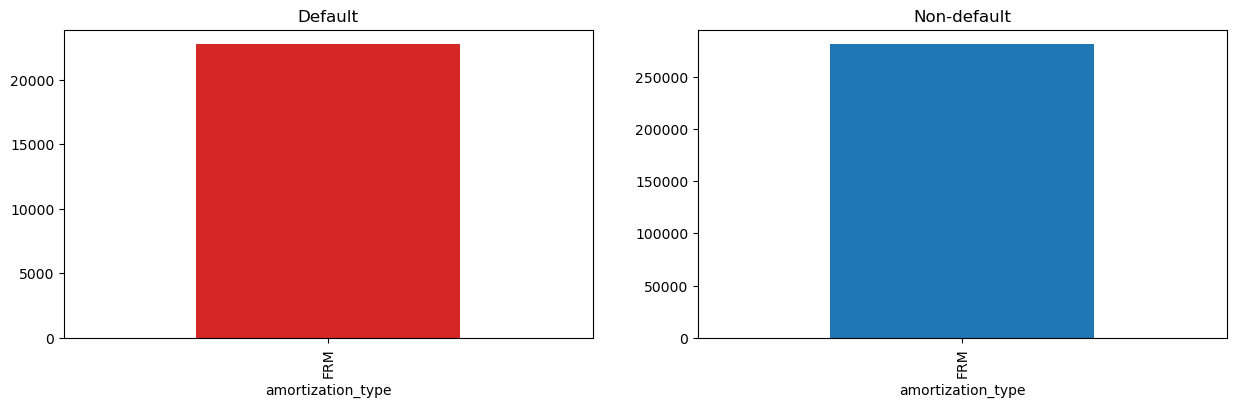

In [653]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

df_default_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[0], color='tab:red')
df_nondefault_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[1])

ax[0].set_title('Default')
ax[1].set_title('Non-default')

plt.show()

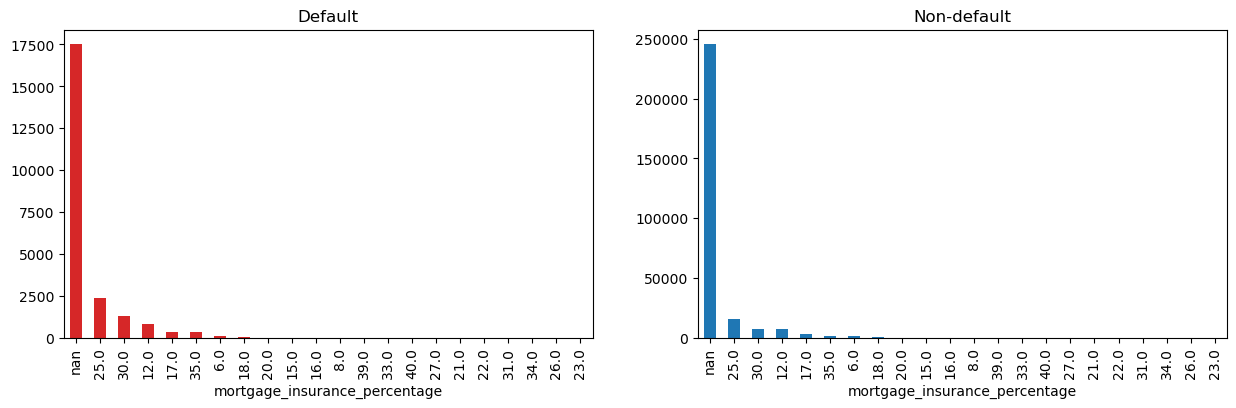

In [651]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

df_default_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[0], color='tab:red')
df_nondefault_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[1])

ax[0].set_title('Default')
ax[1].set_title('Non-default')

plt.show()

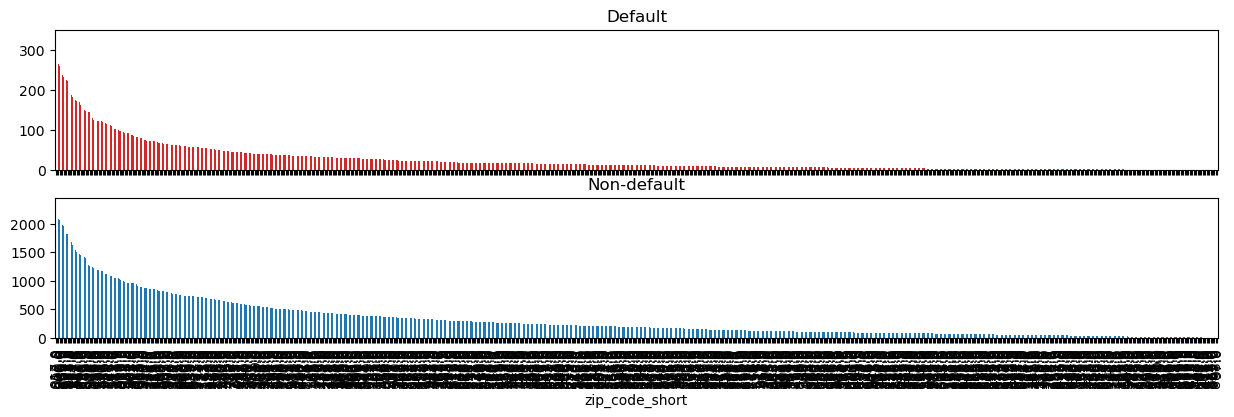

In [646]:
fig, ax = plt.subplots(2, 1, figsize=(15, 4), sharex=True)

df_default_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[0], color='tab:red')
df_nondefault_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[1])

ax[0].set_title('Default')
ax[1].set_title('Non-default')

plt.show()

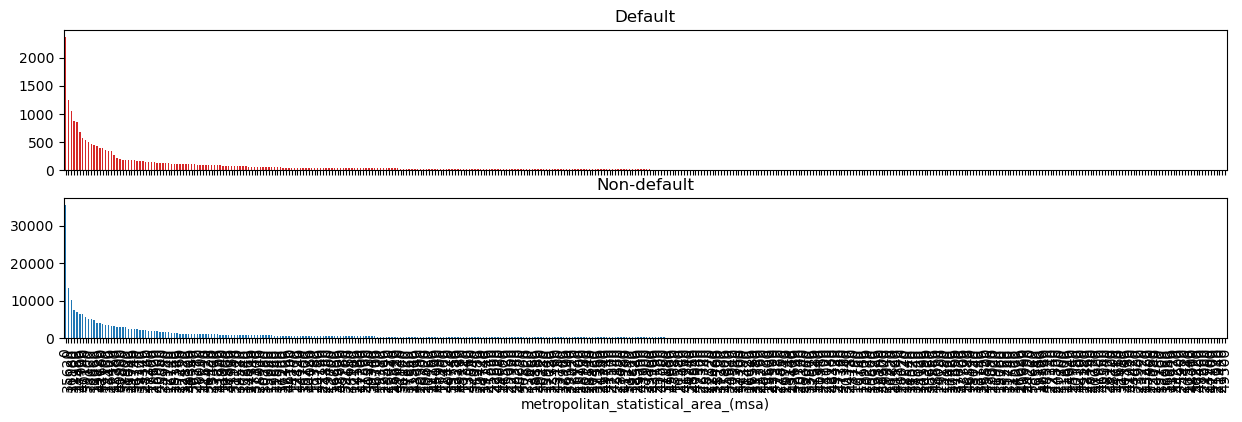

In [642]:
fig, ax = plt.subplots(2, 1, figsize=(15, 4), sharex=True)

df_default_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[0], color='tab:red')
df_nondefault_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[1])

ax[0].set_title('Default')
ax[1].set_title('Non-default')

plt.show()

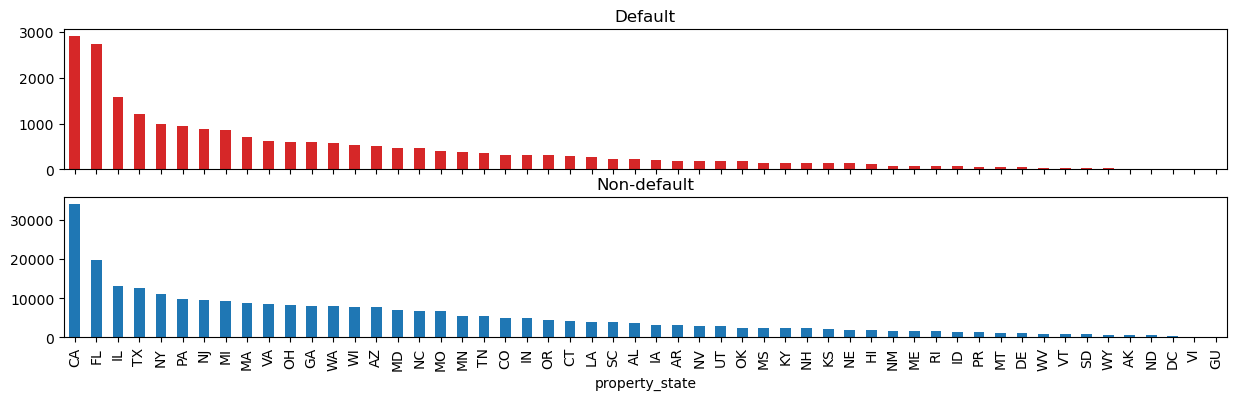

In [640]:
fig, ax = plt.subplots(2, 1, figsize=(15, 4), sharex=True)

df_default_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[0], color='tab:red')
df_nondefault_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[1])

ax[0].set_title('Default')
ax[1].set_title('Non-default')

plt.show()

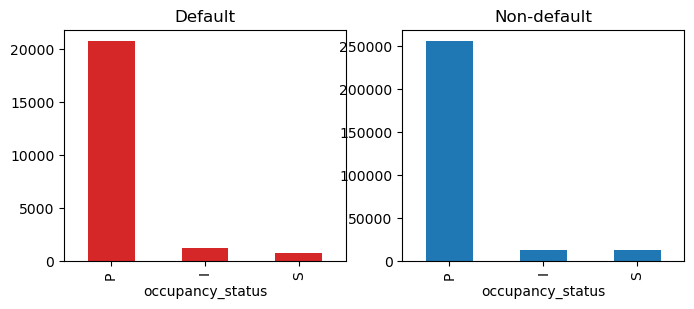

In [633]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

df_default_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[0], color='tab:red')
df_nondefault_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[1])

ax[0].set_title('Default')
ax[1].set_title('Non-default')

plt.show()

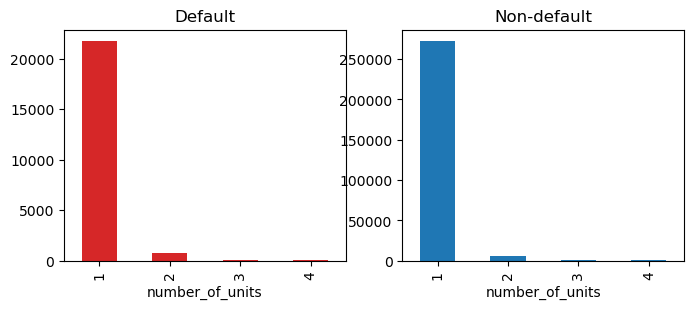

In [628]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

df_default_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[0], color='tab:red')
df_nondefault_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[1])

ax[0].set_title('Default')
ax[1].set_title('Non-default')

plt.show()

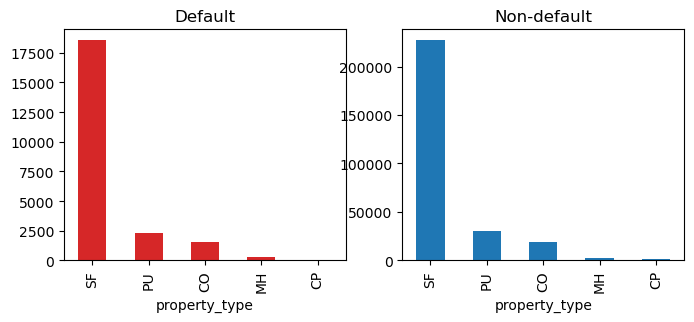

In [625]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

df_default_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[0], color='tab:red')
df_nondefault_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[1])

ax[0].set_title('Default')
ax[1].set_title('Non-default')

plt.show()

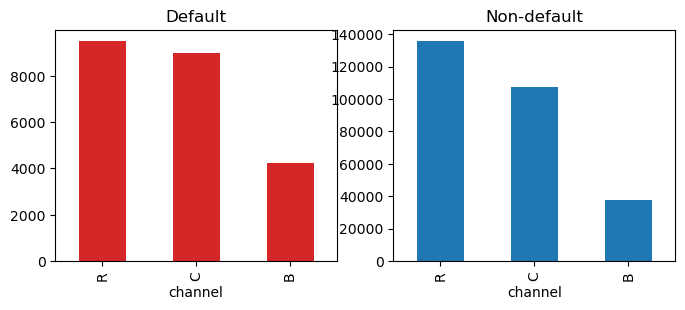

In [626]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

df_default_first['channel'].value_counts(dropna=False).plot(kind='bar', ax=ax[0], color='tab:red')
df_nondefault_first['channel'].value_counts(dropna=False).plot(kind='bar', ax=ax[1])

ax[0].set_title('Default')
ax[1].set_title('Non-default')

plt.show()

# Macroeconomic Variables

1. GDP
    - Source: FRED
    - Converted to YoY percentage change
    - Interpolated monthly
2. Unemployment Rate
    - Source: FRED
    - Already monthly percentage
    - Using the raw unemployment rate
3. Inflation
    -  Source: FRED
    - Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)
    - Converted to YoY percentage change
    - Already monthly
4. House Price Index
    - Source: FRED
    - All-Transactions House Price Index for the United States (USSTHPI)
    - Converted YoY percentage change
    - Interpolated monthly

<font size=3> Not implemented </font>

5. Credit Spreads (Mortgage (MBS)-Treasure yields, CDS on FM-MBS)
6. Unemployment by State
7. HPI by State

### GDP
- Convert to YoY percentage change
- Interpolate monthly

In [9]:
df.head()

,loan_identifier,time,year,channel,original_interest_rate,current_interest_rate,original_upb,current_actual_upb,original_loan_term,loan_age,...,loan_purpose,property_type,number_of_units,occupancy_status,property_state,delinquency_status,zero_balance_code,interest_rate_spread,upb_change_rate,early_payment
4263813,255786094177,2005-01-01,2005,C,5.750,5.750,106000.0,0.0,360,1.0,...,P,SF,1,P,TX,0,NaN,0.0,1.0,True
21985364,906210945847,2005-01-01,2005,B,6.250,6.250,35000.0,0.0,360,0.0,...,R,SF,1,I,AL,0,NaN,0.0,1.0,True
7370051,370893910142,2005-01-01,2005,R,5.750,5.750,122000.0,0.0,360,0.0,...,R,SF,1,P,MI,0,NaN,0.0,1.0,True
2658065,196714859176,2005-01-01,2005,R,6.625,6.625,67000.0,0.0,360,3.0,...,C,CO,1,P,FL,0,NaN,0.0,1.0,True
24325078,991048429580,2005-01-01,2005,C,5.750,5.750,150000.0,0.0,360,2.0,...,R,SF,1,P,CA,0,NaN,0.0,1.0,True


In [10]:
# GDP (YoY%, Monthly linear interpolation)
gdp = (web.DataReader('GDP', 'fred', start=df['time'].min() - pd.DateOffset(years=1), end=df['time'].max()+pd.DateOffset(months=1))\
       .pct_change(4) * 100).dropna()\
       .resample('MS').interpolate(method='linear')\
       .reset_index().rename(columns={'DATE':'time', 'GDP':'gdp'})
gdp

,time,gdp
0,2005-01-01,7.077140
1,2005-02-01,6.946700
2,2005-03-01,6.816260
3,2005-04-01,6.685820
4,2005-05-01,6.725435
...,...,...
233,2024-06-01,5.251997
234,2024-07-01,5.031580
235,2024-08-01,5.030279
236,2024-09-01,5.028978


<Axes: xlabel='time'>

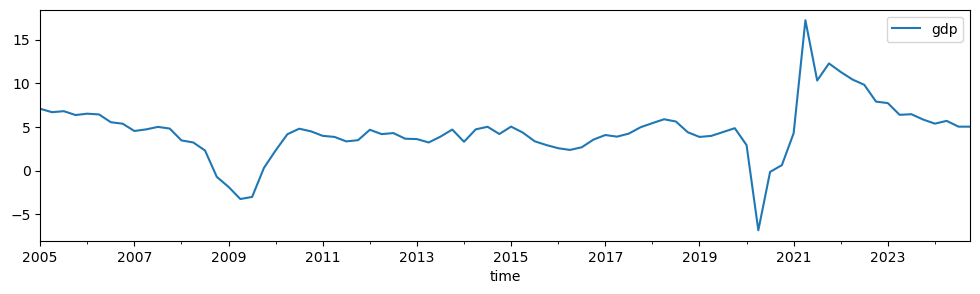

In [496]:
fig, ax = plt.subplots(figsize=(12, 3))
gdp.plot(x='time', y='gdp', ax=ax)

In [499]:
df[['loan_identifier', 'time']].tail().merge(gdp, on='time', how='left')

,loan_identifier,time,gdp
0,416838688281,2024-09-01,5.028978
1,539196144039,2024-09-01,5.028978
2,159078194599,2024-09-01,5.028978
3,843307312026,2024-09-01,5.028978
4,111848816525,2024-09-01,5.028978


### Unemployment Rate
- Already monthly percentage
- Using the raw unemployment rate

In [11]:
unrate = web.DataReader('UNRATE', 'fred', start=df['time'].min(), end=df['time'].max())\
         .reset_index().rename(columns={'DATE':'time', 'UNRATE':'unrate'})
unrate

,time,unrate
0,2005-01-01,5.3
1,2005-02-01,5.4
2,2005-03-01,5.2
3,2005-04-01,5.2
4,2005-05-01,5.1
...,...,...
232,2024-05-01,4.0
233,2024-06-01,4.1
234,2024-07-01,4.2
235,2024-08-01,4.2


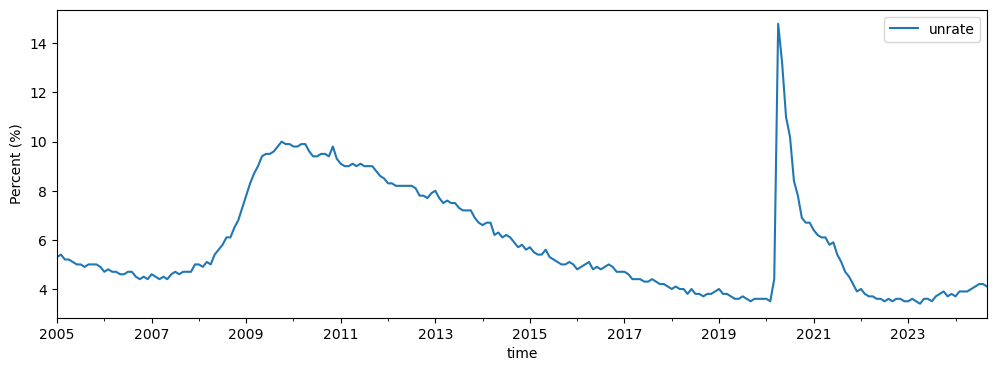

In [395]:
fig, ax = plt.subplots(figsize=(12, 4))

unrate.plot(x='time', y='unrate', ax=ax)
ax.set_ylabel('Percent (%)')

plt.show()

In [500]:
df[['loan_identifier', 'time']].tail().merge(unrate, on='time', how='left')

,loan_identifier,time,unrate
0,416838688281,2024-09-01,4.1
1,539196144039,2024-09-01,4.1
2,159078194599,2024-09-01,4.1
3,843307312026,2024-09-01,4.1
4,111848816525,2024-09-01,4.1


### Inflation (CPI)
- Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)
- Converted to YoY percentage change
- Already monthly

In [12]:
# Inflation: Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)
# Converted to YoY inflation percentage change
cpi = (web.DataReader('CPIAUCSL', 'fred', start=df['time'].min() - pd.DateOffset(years=1), end=df['time'].max())\
           .pct_change(12) * 100).dropna().reset_index().rename(columns={'DATE':'time', 'CPIAUCSL':'cpi'})
cpi

,time,cpi
0,2005-01-01,2.844874
1,2005-02-01,3.053026
2,2005-03-01,3.206841
3,2005-04-01,3.361793
4,2005-05-01,2.869288
...,...,...
232,2024-05-01,3.238866
233,2024-06-01,2.970085
234,2024-07-01,2.938463
235,2024-08-01,2.610914


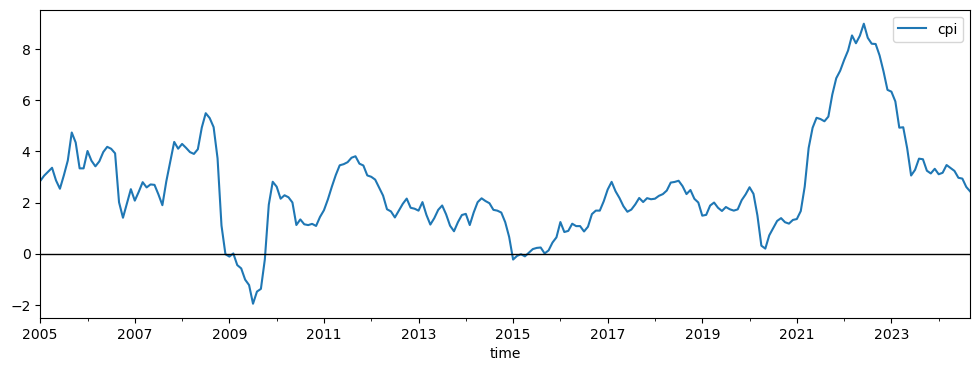

In [428]:
fig, ax = plt.subplots(figsize=(12, 4))

cpi.plot(x='time', y='cpi', ax=ax)
ax.legend()
ax.axhline(y=0, color='k', lw=1)

In [430]:
df[['loan_identifier', 'time']].head().merge(cpi, on='time', how='left')

,loan_identifier,time,cpi
0,370893910142,2005-01-01,2.844874
1,936774229300,2005-01-01,2.844874
2,936772694421,2005-01-01,2.844874
3,680743668300,2005-01-01,2.844874
4,164699402533,2005-01-01,2.844874


### House Price Index (HPI)
- All-Transactions House Price Index for the United States (USSTHPI)
- Converted YoY percentage change
- Interpolated monthly

In [13]:
hpi = (web.DataReader('USSTHPI', 'fred', start=df['time'].min() - pd.DateOffset(years=1), end=df['time'].max()+pd.DateOffset(months=1))\
      .pct_change(4) * 100).dropna()\
      .resample('MS').interpolate(method='linear')\
      .reset_index().rename(columns={'DATE':'time', 'USSTHPI':'hpi'})
hpi

,time,hpi
0,2005-01-01,11.122582
1,2005-02-01,11.398194
2,2005-03-01,11.673807
3,2005-04-01,11.949420
4,2005-05-01,11.670679
...,...,...
233,2024-06-01,5.495693
234,2024-07-01,5.211632
235,2024-08-01,5.264393
236,2024-09-01,5.317154


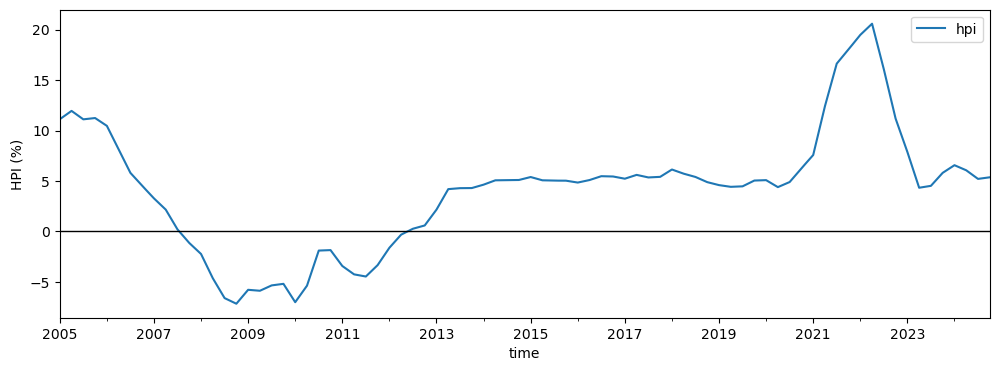

In [502]:
fig, ax = plt.subplots(figsize=(12, 4))
hpi.plot(ax=ax, x='time', y='hpi')
ax.set_ylabel('HPI (%)')
ax.axhline(y=0, color='k', lw=1)
plt.show()

In [503]:
df[['loan_identifier', 'time']].head().merge(hpi, on='time', how='left')

,loan_identifier,time,hpi
0,370893910142,2005-01-01,11.122582
1,936774229300,2005-01-01,11.122582
2,936772694421,2005-01-01,11.122582
3,680743668300,2005-01-01,11.122582
4,164699402533,2005-01-01,11.122582


In [14]:
df_macro = pd.concat([gdp.set_index('time'), 
                      unrate.set_index('time'), 
                      cpi.set_index('time'), 
                      hpi.set_index('time')], 
                     axis=1).reset_index().dropna()

df_macro

,time,gdp,unrate,cpi,hpi
0,2005-01-01,7.077140,5.3,2.844874,11.122582
1,2005-02-01,6.946700,5.4,3.053026,11.398194
2,2005-03-01,6.816260,5.2,3.206841,11.673807
3,2005-04-01,6.685820,5.2,3.361793,11.949420
4,2005-05-01,6.725435,5.1,2.869288,11.670679
...,...,...,...,...,...
232,2024-05-01,5.472413,4.0,3.238866,5.779754
233,2024-06-01,5.251997,4.1,2.970085,5.495693
234,2024-07-01,5.031580,4.2,2.938463,5.211632
235,2024-08-01,5.030279,4.2,2.610914,5.264393


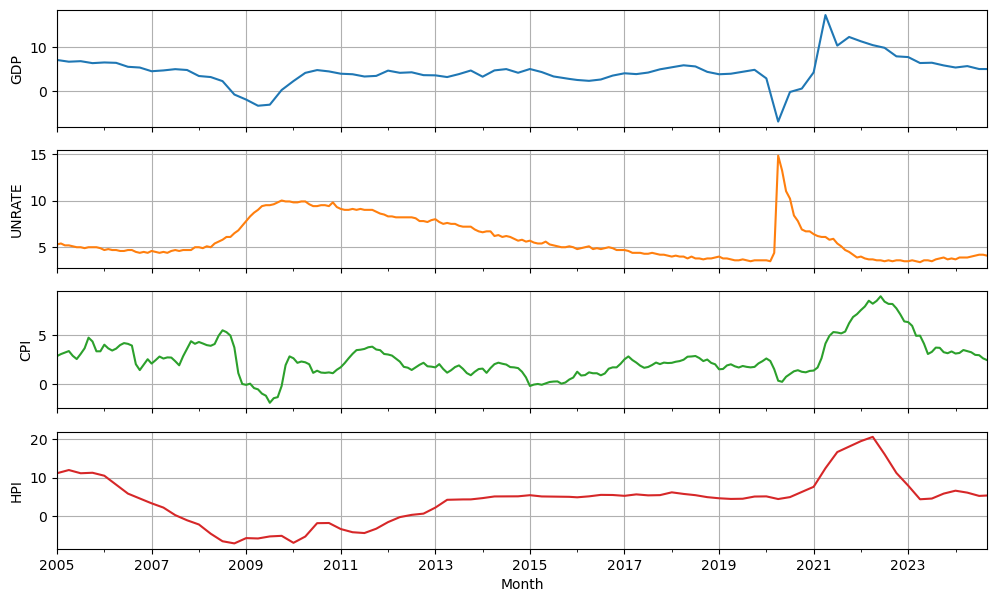

In [153]:
fig, ax = plt.subplots(df_macro.shape[1]-1, 1, figsize=(12, 7), sharex=True)

for i, col in enumerate(df_macro.columns.to_list()[1:]):
    df_macro.set_index('time')[col].plot(ax=ax[i], color=f'C{i}')
    ax[i].set_ylabel(col.upper())
    ax[i].grid(True)
ax[i].set_xlabel('Month')

plt.show()

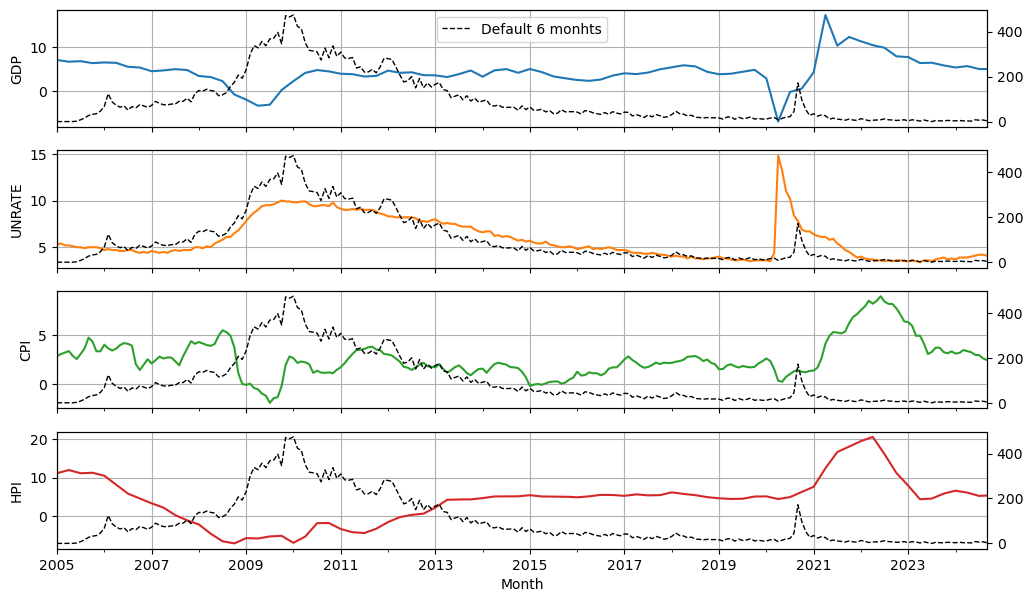

In [51]:
fig, ax = plt.subplots(df_macro.shape[1]-1, 1, figsize=(12, 7), sharex=True)

for i, col in enumerate(df_macro.columns.to_list()[1:]):
    df_macro.set_index('time')[col].plot(ax=ax[i], color=f'C{i}')
    axi = ax[i].twinx()
    dfD6t1.groupby('time')['default'].sum().plot(ax=axi, ls='--', lw=1, color='k', label='Default 6 monhts')
    ax[i].set_ylabel(col.upper())
    ax[i].grid(True)
    if i ==0:
        axi.legend(loc='upper center')
ax[i].set_xlabel('Month')


plt.show()

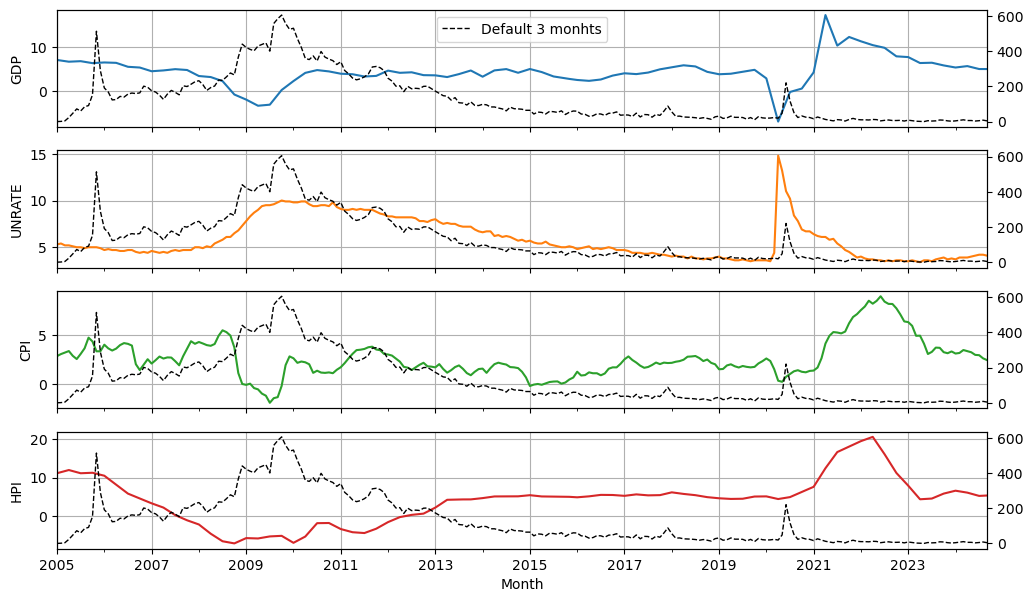

In [52]:
fig, ax = plt.subplots(df_macro.shape[1]-1, 1, figsize=(12, 7), sharex=True)

for i, col in enumerate(df_macro.columns.to_list()[1:]):
    df_macro.set_index('time')[col].plot(ax=ax[i], color=f'C{i}')
    axi = ax[i].twinx()
    dfD3t1.groupby('time')['default'].sum().plot(ax=axi, ls='--', lw=1, color='k', label='Default 3 monhts')
    ax[i].set_ylabel(col.upper())
    ax[i].grid(True)
    if i ==0:
        axi.legend(loc='upper center')
ax[i].set_xlabel('Month')


plt.show()

### Include Macro Vars

In [15]:
%%time
# Include Macroeconomic Variables
df = df.merge(df_macro, on='time', how='left')

CPU times: user 841 ms, sys: 1.11 s, total: 1.95 s
Wall time: 1.95 s


In [16]:
df.head()

,loan_identifier,time,year,channel,original_interest_rate,current_interest_rate,original_upb,current_actual_upb,original_loan_term,loan_age,...,property_state,delinquency_status,zero_balance_code,interest_rate_spread,upb_change_rate,early_payment,gdp,unrate,cpi,hpi
0,255786094177,2005-01-01,2005,C,5.750,5.750,106000.0,0.0,360,1.0,...,TX,0,NaN,0.0,1.0,True,7.07714,5.3,2.844874,11.122582
1,906210945847,2005-01-01,2005,B,6.250,6.250,35000.0,0.0,360,0.0,...,AL,0,NaN,0.0,1.0,True,7.07714,5.3,2.844874,11.122582
2,370893910142,2005-01-01,2005,R,5.750,5.750,122000.0,0.0,360,0.0,...,MI,0,NaN,0.0,1.0,True,7.07714,5.3,2.844874,11.122582
3,196714859176,2005-01-01,2005,R,6.625,6.625,67000.0,0.0,360,3.0,...,FL,0,NaN,0.0,1.0,True,7.07714,5.3,2.844874,11.122582
4,991048429580,2005-01-01,2005,C,5.750,5.750,150000.0,0.0,360,2.0,...,CA,0,NaN,0.0,1.0,True,7.07714,5.3,2.844874,11.122582


# Feature Engineering

- Lag features missing
- Rolling window features missing

Notes:

debt_to_income_(dti):
- Missing values: 6.8636% missing values of all entries.
- Loan IDs: 7% missing DTI
- Defaulted Loan IDs: 8.1% missing DTI
- Number of unique values: 64
- Solution: leave nan and let XGB/LGBM handle.
  
credit_score:
- This feature is the minimum between the features ['borrower_credit_score_at_origination', 'co_borrower_credit_score_at_origination']

Check property_type and number_of_units. Maybe remove one.

Check loan_purpose importance. Might be removable.

Check if LTV and CLTV are both needed. Shap values for instance.

### Credit Score

In [7]:
# Credit Score
credit_score = df[['borrower_credit_score_at_origination', 'co_borrower_credit_score_at_origination']].min(axis=1)
df.insert(df.columns.get_loc('borrower_credit_score_at_origination'), 'credit_score', credit_score)
df.drop(['borrower_credit_score_at_origination', 'co_borrower_credit_score_at_origination'], axis=1, inplace=True)

## Rolling Window Features

Notes:

- Some temporal features like seasonality features–the month of the loan origination date, or loan vintage–origination year, are not interesting now because we are using 2015Q1 only.

# HERE

In [8]:
# --- Credit Risk Related ---
# Interest Rate Spread
df['interest_rate_spread'] = df['original_interest_rate'] - df['current_interest_rate']

# --- Payment Behaviour ---
# UPB Change Rate
df['upb_change_rate'] = 1 - df['current_actual_upb']/df['original_upb']
# Early Payment Indicator
df['early_payment'] = (df['loan_age'] < 12) & (df['upb_change_rate'] > 0.1)

In [ ]:
# Not included
df["upb_rolling_mean_3"] = df.groupby("Loan_ID")["current_actual_upb"].rolling(window=3).mean().reset_index(0, drop=True)
df["interest_rate_volatility_3"] = df.groupby("Loan_ID")["current_interest_rate"].rolling(window=3).std().reset_index(0, drop=True)


## Lag Features

In [17]:
%%time

df = df.sort_values(by=['loan_identifier', 'time'])
print('Sorted 1')

# Payment Behaviour
df['delinquency_status_lag1'] = df.groupby('loan_identifier')['delinquency_status'].shift(1).bfill()
# df["current_actual_upb_lag1"] = df.groupby("Loan_ID")["current_actual_upb"].shift(1)
# df["interest_rate_lag1"] = df.groupby("Loan_ID")["current_interest_rate"].shift(1)
print('Payment Behaviour Lag')

# Macroeconomic Variables
df['gdp_lag3'] = df.groupby('loan_identifier')['gdp'].shift(3).bfill()
df['unrate_lag1'] = df.groupby('loan_identifier')['unrate'].shift(1).bfill()
df['cpi_lag1'] = df.groupby('loan_identifier')['cpi'].shift(1).bfill()
df['hpi_lag3'] = df.groupby('loan_identifier')['hpi'].shift(3).bfill()
print('Macro Lag')

df = df.sort_values(by='time')

Sorted 1
Payment Behaviour Lag
Macro Lag
CPU times: user 18 s, sys: 2.53 s, total: 20.5 s
Wall time: 20.9 s


In [112]:
print(' --- Macroeconomic Variables Lag ---')
print(' GDP: 3')
print(' UNRATE: 1')
print(' CPI: 1')
print(' HPI: 3')

 --- Macroeconomic Variables Lag ---
 GDP: 3
 UNRATE: 1
 CPI: 1
 HPI: 3


In [640]:
corr_macro = pd.concat([df.groupby('time')['default'].sum().to_frame(), df_macro.set_index('time')], axis=1).corr()
# sns.heatmap(corr_macro, annot=True)
corr_macro.loc['default', macro_vars].to_frame()

,default
gdp,-0.469197
unrate,0.700844
cpi,-0.300315
hpi,-0.739060


In [98]:
def lag_corr_macro(df):
    corr_macro = pd.DataFrame()
    for lag in range(7):
        corr_lag = pd.concat([df.groupby('time')['default'].sum().to_frame(),
                              df_macro.set_index('time').shift(lag)], axis=1).dropna().corr()
        corr_macro = pd.concat([corr_macro, corr_lag.loc['default', macro_vars].to_frame().rename(columns={'default':f'lag_{lag}'}).T])
    return corr_macro
lag_corr_macro(dfD3t1)

,gdp,unrate,cpi,hpi
lag_0,-0.469197,0.700844,-0.300315,-0.739060
lag_1,-0.489835,0.695172,-0.298419,-0.738380
lag_2,-0.505469,0.682973,-0.289415,-0.737900
lag_3,-0.506228,0.638722,-0.281654,-0.736324
lag_4,-0.498670,0.603689,-0.270849,-0.734444
lag_5,-0.487560,0.576895,-0.258608,-0.731242
lag_6,-0.478813,0.553513,-0.240690,-0.726887


In [99]:
corr_macro = {}
for k in metrics_macro.keys():
    corr_macro[k] = lag_corr_macro(datasets[k])

In [112]:
print(' --- Macroeconomic Variables Lag ---')
print(' GDP: 3')
print(' UNRATE: 1')
print(' CPI: 1')
print(' HPI: 3')

 --- Macroeconomic Variables Lag ---
 GDP: 3
 UNRATE: 1
 CPI: 1
 HPI: 3


<Axes: >

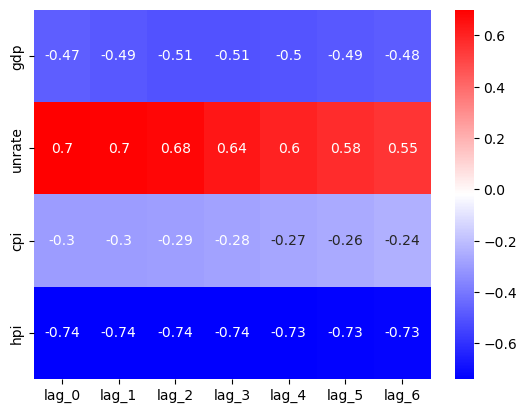

In [111]:
sns.heatmap(corr_macro['D3t1'].T, cmap='bwr', annot=True)

<Axes: >

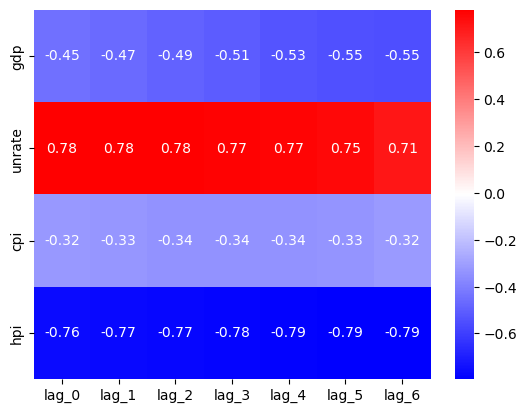

In [110]:
sns.heatmap(corr_macro['D6t1'].T, cmap='bwr', annot=True)

## Selected Features

In [18]:
# --- Predictors

# Numerical variables
numerical_vars = ['original_interest_rate',
                  'current_interest_rate',
                  'original_upb',
                  'current_actual_upb',
                  'original_loan_term',
                  'loan_age',
                  'remaining_months_to_maturity',
                  'ltv',
                  'cltv',
                  'dti',
                  'credit_score',
                  'delinquency_status',
                  'delinquency_status_lag1'
                 ]
# macro_vars = ['gdp', 'unrate', 'cpi', 'hpi']
macro_vars = ['gdp_lag3', 'unrate_lag1', 'cpi_lag1', 'hpi_lag3']
rolling_vars = ['interest_rate_spread', 'upb_change_rate', 'early_payment']
# Frequency encoding variables
freq_enc_vars = []
# Target encoding variables
target_enc_vars = ['property_state']
# One-hot encoding variables
onehot_enc_vars = ['channel', 'loan_purpose', 'property_type', 'occupancy_status']
# Ordinal encoding variables
ordinal_enc_vars = ['number_of_borrowers', 'number_of_units']
# Categorical variables
cat_vars = freq_enc_vars+target_enc_vars+onehot_enc_vars+ordinal_enc_vars
# List of all predictors before encoding
all_vars = numerical_vars+macro_vars+cat_vars+rolling_vars
# Geographical features for class imbalance oversampling (if used)
geo_vars = []

features = {
    'numerical_vars':numerical_vars,
    'macro_vars':macro_vars,
    'rolling_vars':rolling_vars,
    'freq_enc_vars':freq_enc_vars,
    'target_enc_vars':target_enc_vars,
    'onehot_enc_vars':onehot_enc_vars,
    'ordinal_enc_vars':ordinal_enc_vars,
    'cat_vars':cat_vars,
    'all_vars':all_vars,
}

# df[cat_vars] = df[cat_vars].astype('category')

# Logging configuration
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [59]:
def feature_summary(features):

    # Variable sets
    all_vars = features['all_vars']
    numerical_vars = features['numerical_vars']
    macro_vars = features['macro_vars']
    rolling_vars = features['rolling_vars']
    target_enc_vars = features['target_enc_vars']
    freq_enc_vars = features['freq_enc_vars']
    ordinal_enc_vars = features['ordinal_enc_vars']
    onehot_enc_vars = features['onehot_enc_vars']
    
    print(f'Total number of features: {len(all_vars)}')
    print(f' --- Numerical Variables ---')
    print(f' Total number of numerical variables: {len(numerical_vars)+len(macro_vars)}')
    print(f' Numerical features:')
    display(df[numerical_vars].describe())
    print(f'Macroeconomic variables:')
    display(df[macro_vars].describe())
    print(f' --- Categorical Variables ---')
    print(f' Total number of categorical variables: {len(cat_vars)}')
    display(df[cat_vars].describe(include='all'))

In [61]:
feature_summary(features)

Total number of features: 27
 --- Numerical Variables ---
 Total number of numerical variables: 17
 Numerical features:


,original_interest_rate,current_interest_rate,original_upb,current_actual_upb,original_loan_term,loan_age,remaining_months_to_maturity,ltv,cltv,dti,credit_score,delinquency_status,delinquency_status_lag1
count,2.455195e+07,2.425906e+07,2.455195e+07,2.455195e+07,2.455195e+07,2.425876e+07,2.338168e+07,2.455195e+07,2.455076e+07,2.285421e+07,2.447371e+07,2.455195e+07,2.455195e+07
mean,5.664123e+00,5.603342e+00,1.560632e+05,1.223008e+05,3.111750e+02,6.053016e+01,2.451366e+02,6.846288e+01,7.000656e+01,3.596098e+01,7.161719e+02,3.310341e-01,3.083869e-01
std,3.681172e-01,5.357591e-01,8.226954e+04,8.519670e+04,7.885051e+01,4.993049e+01,9.515559e+01,1.748827e+01,1.809934e+01,1.316314e+01,5.954612e+01,2.895703e+00,2.833396e+00
min,2.990000e+00,2.000000e+00,7.000000e+03,0.000000e+00,6.000000e+01,-1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+02,0.000000e+00,0.000000e+00
25%,5.500000e+00,5.375000e+00,9.200000e+04,5.955123e+04,2.400000e+02,2.200000e+01,1.670000e+02,5.800000e+01,6.000000e+01,2.600000e+01,6.730000e+02,0.000000e+00,0.000000e+00
50%,5.750000e+00,5.750000e+00,1.400000e+05,1.085371e+05,3.600000e+02,4.800000e+01,2.790000e+02,7.300000e+01,7.400000e+01,3.600000e+01,7.200000e+02,0.000000e+00,0.000000e+00
75%,5.875000e+00,5.875000e+00,2.040000e+05,1.736588e+05,3.600000e+02,8.500000e+01,3.260000e+02,8.000000e+01,8.000000e+01,4.500000e+01,7.670000e+02,0.000000e+00,0.000000e+00
max,9.000000e+00,9.000000e+00,6.920000e+05,9.099339e+05,3.600000e+02,2.740000e+02,4.800000e+02,9.700000e+01,1.930000e+02,6.400000e+01,8.500000e+02,1.000000e+02,9.900000e+01


Macroeconomic variables:


,gdp_lag3,unrate_lag1,cpi_lag1,hpi_lag3
count,2.455195e+07,2.455195e+07,2.455195e+07,2.455195e+07
mean,4.050192e+00,6.325451e+00,2.464082e+00,2.277038e+00
std,2.675229e+00,2.026212e+00,1.595700e+00,6.298588e+00
min,-6.834743e+00,3.400000e+00,-1.958761e+00,-7.157524e+00
25%,3.375133e+00,4.700000e+00,1.557759e+00,-3.709469e+00
50%,4.492620e+00,5.200000e+00,2.582875e+00,2.911598e+00
75%,5.833435e+00,8.300000e+00,3.610698e+00,6.256470e+00
max,1.722268e+01,1.480000e+01,8.999298e+00,2.058737e+01


 --- Categorical Variables ---
 Total number of categorical variables: 7


,property_state,channel,loan_purpose,property_type,occupancy_status,number_of_borrowers,number_of_units
count,24551951,24551951,24551951,24551951,24551951,2.455139e+07,2.455195e+07
unique,54,3,4,5,3,NaN,NaN
top,CA,R,C,SF,P,NaN,NaN
freq,2773919,11910184,9688413,19974809,22217548,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,1.571597e+00,1.045866e+00
std,NaN,NaN,NaN,NaN,NaN,5.107515e-01,2.664891e-01
min,NaN,NaN,NaN,NaN,NaN,1.000000e+00,1.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,1.000000e+00,1.000000e+00
50%,NaN,NaN,NaN,NaN,NaN,2.000000e+00,1.000000e+00
75%,NaN,NaN,NaN,NaN,NaN,2.000000e+00,1.000000e+00


## Encoding/Scaling

In [30]:
# --- Encoding/Scaling ---

def encode_scale_data(X_train: pd.DataFrame, 
                      X_test: pd.DataFrame, 
                      y_train: pd.Series, 
                      numerical_vars: List[str]=None, 
                      target_enc_vars: List[str]=None, 
                      freq_enc_vars: List[str]=None, 
                      ordinal_enc_vars: List[str]=None,
                      onehot_enc_vars: List[str]=None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    ''' Encode and scale data. '''
    pd.set_option('future.no_silent_downcasting', True)
    
    # Target encoding
    if target_enc_vars:
        target_encoder = TargetEncoder(cols=target_enc_vars)
        X_train = target_encoder.fit_transform(X_train, y_train)
        X_test = target_encoder.transform(X_test)
    
    # Frequency encoding
    if freq_enc_vars:
        freq_encoder = CountEncoder(cols=freq_enc_vars)
        X_train = freq_encoder.fit_transform(X_train, y_train)
        X_test = freq_encoder.transform(X_test)
    
    # Scaling
    if numerical_vars:
        scaler = StandardScaler(with_mean=True, with_std=True).set_output(transform="pandas")
        scale_cols = numerical_vars+freq_enc_vars+target_enc_vars
        scaler.fit(X_train[scale_cols])
        X_train = pd.concat([X_train.drop(scale_cols, axis=1), scaler.transform(X_train[scale_cols])], axis=1)
        X_test = pd.concat([X_test.drop(scale_cols, axis=1), scaler.transform(X_test[scale_cols])], axis=1)

    # Ordinal encoding
    if ordinal_enc_vars:
        ordinal_encoder = OrdinalEncoder()
        X_train.loc[:, ordinal_enc_vars] = ordinal_encoder.fit_transform(X_train[ordinal_enc_vars])
        X_test.loc[:, ordinal_enc_vars] = ordinal_encoder.transform(X_test[ordinal_enc_vars])
    
    # One-hot encoding
    if onehot_enc_vars:
        onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        
        # Fit-transform variables
        X_train_onehot = pd.DataFrame(onehot_encoder.fit_transform(X_train[onehot_enc_vars].astype('str')))
        X_train_onehot.columns = onehot_encoder.get_feature_names_out()
        X_train_onehot.index = X_train.index

        X_test_onehot = pd.DataFrame(onehot_encoder.transform(X_test[onehot_enc_vars].astype('str')))
        X_test_onehot.columns = onehot_encoder.get_feature_names_out()
        X_test_onehot.index = X_test.index
        
        # Remove original categorical variables
        X_train.drop(onehot_enc_vars, axis=1, inplace=True)
        X_test.drop(onehot_enc_vars, axis=1, inplace=True)
        
        # Concatenate data set with one-hot columns
        X_train = pd.concat([X_train, X_train_onehot], axis=1)
        X_test = pd.concat([X_test, X_test_onehot], axis=1)


    return X_train, X_test

## Class imbalance

In [50]:
def combine_geography(df, geo_vars=None):
    df = df.copy()
    var_name = '_'.join(geo_vars)
    df.insert(df.columns.get_loc(geo_vars[0]), var_name, df[geo_vars].agg('_'.join, axis=1))
    df.drop(geo_vars, axis=1, inplace=True)
    return df

def split_geography(df, geo_vars=None):
    var_name = '_'.join(geo_vars)
    idx = df.columns.get_loc(var_name)
    df_split = df[var_name].str.split('_', expand=True)
    df_split.columns = geo_vars
    return pd.concat([df.iloc[:, :idx], df_split, df.iloc[:, idx:]], axis=1).drop(var_name, axis=1)

def aux(X, variables=None, p=False):
    for var in variables:
        print(var, X[var].nunique())
        if p:
            print(X[var].unique())

# Class imbalance
def class_imbalance(X_train, y_train, 
                    over_sample=True,
                    over_sample_ratio='auto',
                    under_sample=True, 
                    under_sample_ratio='auto', 
                    geo_vars=None, 
                    cat_vars=None):

    # Undersample
    if under_sample:
        # Random Under Sampler
        undersampler = RandomUnderSampler(sampling_strategy=under_sample_ratio, random_state=1)
        X_train, y_train = undersampler.fit_resample(X_train, y_train)
        
    # Oversample
    if over_sample:
        if geo_vars is None:
            raise ValueError("geo_vars cannot be None")
        if cat_vars is None:
            raise ValueError("geo_vars cannot be None")
        # Combine geographical features
        X_train = combine_geography(X_train, geo_vars=geo_vars)
    
        # SMOTENC
        categorical_features = [v for v in cat_vars if v not in geo_vars]+['_'.join(geo_vars)]
        smotenc = SMOTENC(categorical_features=categorical_features, random_state=1)
        X_train, y_train = smotenc.fit_resample(X_train, y_train)
    
        # Split geographical features
        X_train = split_geography(X_train, geo_vars=geo_vars)

    return X_train, y_train

# Definition of Default

- Two variable are used to define default: 'Zero Balance Code' and the delinquency status ('Current Loan Delinquency Status')
- Zero Balance Codes that are a default event: 3 (Short Sale), 9 (Deed-in-Lieu/REO Disposition), 15 (Non-Performing Note Sale)
- Delinquency status for default can be 3 months (> 90 days) or 6 months (> 180 days), etc.
- There is a small number of loans (64) with unknow delinquency status (XX) and with nan zero balance code. These loans are removed, their whole history.
- All the other XX delinquency status end with a zero balance code. For those entries, the XX delinquency status is replaced by the previous delinquency status plus 1.
- The definition of default is then a zero balance code equal to 3, 9, or 15, or a delinquency equal or greater to 3 (or 6) months.

### Zero Balance Code

There is a considerable number of entries with nan zb code. This is fine because it just means these loans are still performing. The only problem is when the zb code is nan and the delinquency status is unknown (XX). There are only 64 loans with nan zb code and XX delinquency status. These loans can be removed.

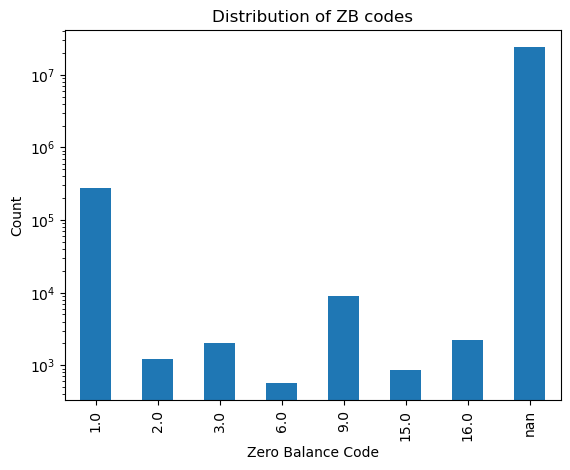

In [316]:
fig, ax = plt.subplots()
df.zero_balance_code.value_counts(dropna=False).sort_index().plot(kind='bar', logy=True, ax=ax)
ax.set_ylabel('Count')
ax.set_xlabel('Zero Balance Code')
ax.set_title('Distribution of ZB codes')
plt.show()

In [324]:
def compute_XX_zbNaN(df):
    df_entries_XX_zbNaN = df.loc[(df.zero_balance_code.isna()) & (df.delinquency_status == 'XX')]
    loan_ids = df_entries_XX_zbNaN['loan_identifier'].unique()
    num_entries_XX_zbNaN = len(df_entries_XX_zbNaN)
    num_loans_XX_zbNaN = df_entries_XX_zbNaN['loan_identifier'].nunique()
    total_entries = len(df.loc[df['loan_identifier'].isin(loan_ids)])
    return num_entries_XX_zbNaN, num_loans_XX_zbNaN, total_entries

In [330]:
num_entries_XX_zbNaN, num_loans_XX_zbNaN, total_num_entries = compute_XX_zbNaN(df)
print(f'Number of entries with unknown delinquency status and nan zero balance code: {num_entries_XX_zbNaN}.')
print(f'Number of loans with unknown delinquency status and nan zero balance code: {num_loans_XX_zbNaN}.')
print(f'Total number of entries related these loans: {total_num_entries}')
print(f'Percentage with respect to the whole dataset: {100*total_num_entries/len(df):.2f}%')

Number of entries with unknown delinquency status and nan zero balance code: 69.
Number of loans with unknown delinquency status and nan zero balance code: 64.
Total number of entries related these loans: 8219
Percentage with respect to the whole dataset: 0.03%


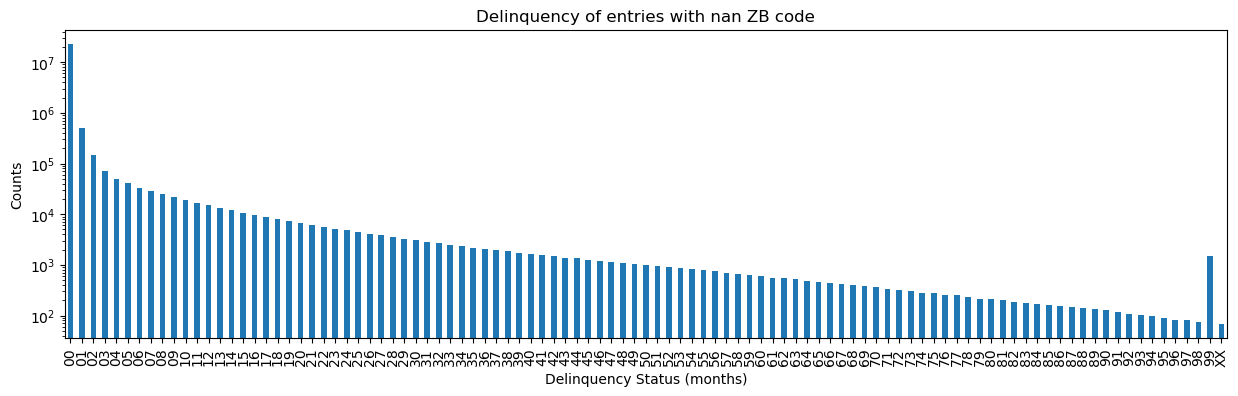

In [317]:
fig, ax = plt.subplots(figsize=(15, 4))
df.loc[df.zero_balance_code.isna()].delinquency_status.value_counts(dropna=False).sort_index().plot(kind='bar', logy=True, ax=ax)
ax.set_xlabel('Delinquency Status (months)')
ax.set_ylabel('Counts')
ax.set_title('Delinquency of entries with nan ZB code')
plt.show()

<font size="6"> Short Sale: ZB code = 3 </font>

In [153]:
df.loc[df.zero_balance_code == 3]['delinquency_status'].value_counts(dropna=False).sort_index().to_frame()

,count
delinquency_status,
00,1
06,1
09,1
10,2
13,1
19,2
25,1
31,1
73,1


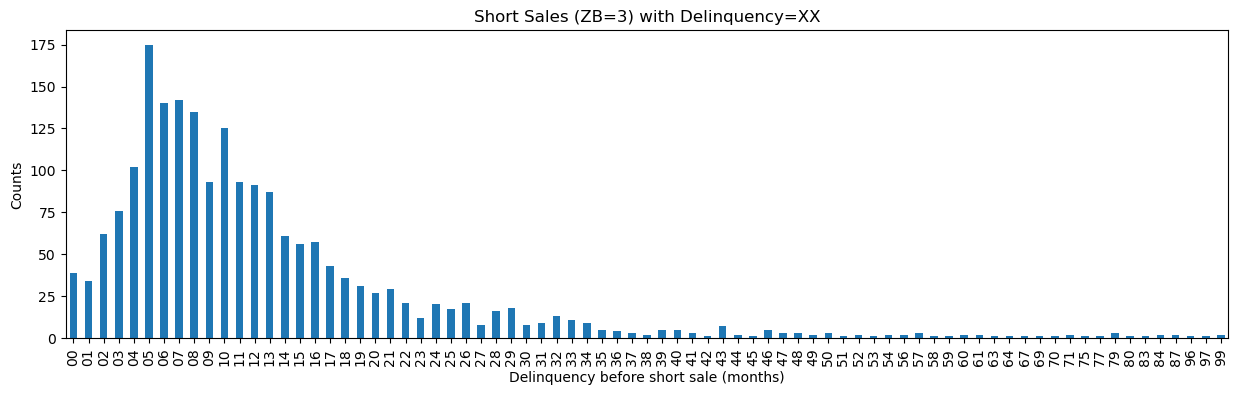

In [302]:
fig, ax= plt.subplots(figsize=(15, 4))
id_zb3_deliXX = df.loc[(df.zero_balance_code == 3) & (df.delinquency_status == 'XX')]['loan_identifier']
df.loc[df.loan_identifier.isin(id_zb3_deliXX)][['loan_identifier', 
                                            'time', 
                                            'zero_balance_code',  
                                            'delinquency_status', 
                                            'original_upb', 
                                            'current_actual_upb','zero_balance_effective_date', 'upb_at_the_time_of_removal']]\
.groupby('loan_identifier', as_index=False).nth(-2)['delinquency_status'].value_counts(dropna=False).sort_index().plot(kind='bar', ax=ax)
ax.set_ylabel('Counts')
ax.set_xlabel('Delinquency before short sale (months)')
ax.set_title('Short Sales (ZB=3) with Delinquency=XX')

plt.show()

<font size="3"> Example 1: ZB code = 3, Delinquency = 0 </font>

In [62]:
df.loc[(df.zero_balance_code == 3) & (df.delinquency_status == '00')]

,loan_identifier,time,year,channel,original_interest_rate,current_interest_rate,original_upb,current_actual_upb,original_loan_term,loan_age,...,upb_at_the_time_of_removal,total_principal_current,last_paid_installment_date,foreclosure_date,special_eligibility_program,property_valuation_method,high_balance_loan_indicator,borrower_assistance_plan,alternative_delinquency_resolution,alternative_delinquency_resolution_count
18179130,766994788392,2021-03-01,2021,R,5.875,5.875,46000.0,0.0,360,NaN,...,30634.77,0.0,32021.0,32021.0,7,NaN,N,7,7,NaN


In [81]:
df.loc[df.loan_identifier == 766994788392][['loan_identifier', 
                                            'time', 
                                            #'zero_balance_code',  
                                            'delinquency_status', 
                                            'loan_age', 
                                            'debt_to_income_(dti)', 
                                            'original_upb', 
                                            'current_actual_upb','zero_balance_effective_date', 'upb_at_the_time_of_removal', 'total_principal_current']].iloc[5:]

,loan_identifier,time,delinquency_status,loan_age,debt_to_income_(dti),original_upb,current_actual_upb,zero_balance_effective_date,upb_at_the_time_of_removal,total_principal_current
18178941,766994788392,2005-06-01,00,5.0,32.0,46000.0,0.00,NaN,NaN,NaN
18178942,766994788392,2005-07-01,00,6.0,32.0,46000.0,45218.24,NaN,NaN,NaN
18178943,766994788392,2005-08-01,00,7.0,32.0,46000.0,45170.47,NaN,NaN,NaN
18178944,766994788392,2005-09-01,00,8.0,32.0,46000.0,45122.47,NaN,NaN,NaN
18178945,766994788392,2005-10-01,00,9.0,32.0,46000.0,45074.23,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
18179126,766994788392,2020-11-01,00,190.0,32.0,46000.0,30988.80,NaN,NaN,116.86
18179127,766994788392,2020-12-01,00,191.0,32.0,46000.0,30871.37,NaN,NaN,117.43
18179128,766994788392,2021-01-01,00,192.0,32.0,46000.0,30753.36,NaN,NaN,118.01
18179129,766994788392,2021-02-01,00,193.0,32.0,46000.0,30634.77,NaN,NaN,118.59


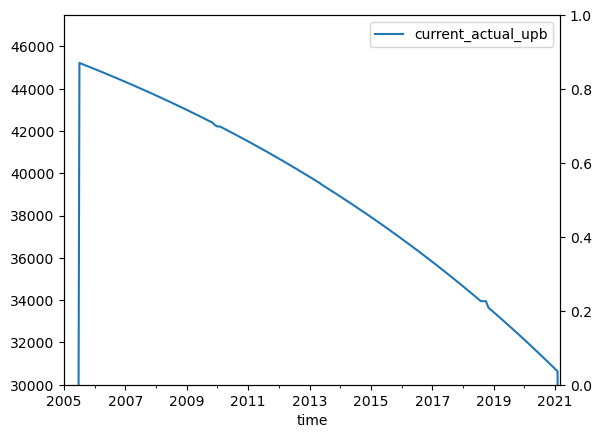

In [93]:
fig, ax = plt.subplots()
df.loc[df.loan_identifier == 766994788392].plot(x='time', y='current_actual_upb', ax = ax)
ax.set_ylim(bottom=3e4)

ax1 = ax.twinx()
# df.loc[df.loan_identifier == 766994788392].plot(x='time', y='delinquency_status', ax = ax1)

<font size="3"> Example 2: ZB code = 3, Delinquency = 73</font>

In [82]:
df.loc[(df.zero_balance_code == 3) & (df.delinquency_status == '73')]

,loan_identifier,time,year,channel,original_interest_rate,current_interest_rate,original_upb,current_actual_upb,original_loan_term,loan_age,...,upb_at_the_time_of_removal,total_principal_current,last_paid_installment_date,foreclosure_date,special_eligibility_program,property_valuation_method,high_balance_loan_indicator,borrower_assistance_plan,alternative_delinquency_resolution,alternative_delinquency_resolution_count
3688320,234620717357,2024-01-01,2024,B,5.875,5.875,135000.0,0.0,360,NaN,...,99399.84,0.0,122017.0,12024.0,7,NaN,N,7,7.0,NaN


In [86]:
df.loc[df.loan_identifier == 234620717357][['loan_identifier', 
                                            'time', 
                                            'zero_balance_code',  
                                            'delinquency_status', 
                                            'loan_age', 
                                            'debt_to_income_(dti)', 
                                            'original_upb', 
                                            'current_actual_upb','zero_balance_effective_date', 'upb_at_the_time_of_removal', 'total_principal_current']].iloc[5:]

,loan_identifier,time,zero_balance_code,delinquency_status,loan_age,debt_to_income_(dti),original_upb,current_actual_upb,zero_balance_effective_date,upb_at_the_time_of_removal,total_principal_current
3688098,234620717357,2005-07-01,NaN,00,6.0,54.0,135000.0,0.00,NaN,NaN,NaN
3688099,234620717357,2005-08-01,NaN,00,7.0,54.0,135000.0,133998.80,NaN,NaN,NaN
3688100,234620717357,2005-09-01,NaN,00,8.0,54.0,135000.0,133855.55,NaN,NaN,NaN
3688101,234620717357,2005-10-01,NaN,00,9.0,54.0,135000.0,133711.59,NaN,NaN,NaN
3688102,234620717357,2005-11-01,NaN,00,10.0,54.0,135000.0,133566.93,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3688316,234620717357,2023-09-01,NaN,69,224.0,54.0,135000.0,99399.84,NaN,NaN,0.0
3688317,234620717357,2023-10-01,NaN,70,225.0,54.0,135000.0,99399.84,NaN,NaN,0.0
3688318,234620717357,2023-11-01,NaN,71,226.0,54.0,135000.0,99399.84,NaN,NaN,0.0
3688319,234620717357,2023-12-01,NaN,72,227.0,54.0,135000.0,99399.84,NaN,NaN,0.0


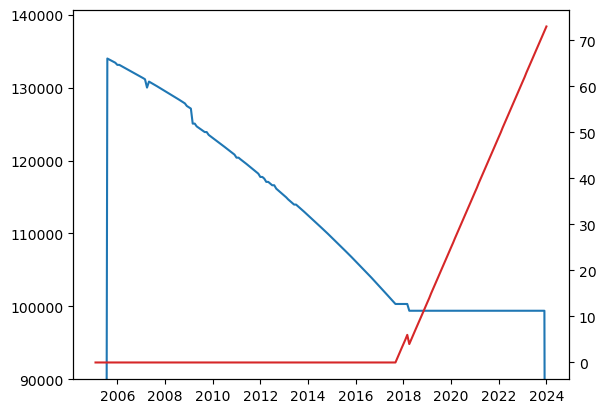

In [106]:
fig, ax = plt.subplots()

x=df.loc[df.loan_identifier == 234620717357]['time']
y=df.loc[df.loan_identifier == 234620717357]['current_actual_upb']
y1=df.loc[df.loan_identifier == 234620717357]['delinquency_status'].astype(int)

ax.plot(x, y)
ax1 = ax.twinx()
ax1.plot(x, y1, color='tab:red')

ax.set_ylim(bottom=9e4)

plt.show()

<font size="3"> Example 3: ZB code = 3, Delinquency = XX </font>

In [126]:
id_zb3_deliXX = df.loc[(df.zero_balance_code == 3) & (df.delinquency_status == 'XX')]['loan_identifier']
df.loc[df.loan_identifier.isin(id_zb3_deliXX)][['loan_identifier', 
                                            'time', 
                                            'zero_balance_code',  
                                            'delinquency_status', 
                                            'original_upb', 
                                            'current_actual_upb','zero_balance_effective_date', 'upb_at_the_time_of_removal']]\
.groupby('loan_identifier', as_index=False).tail(2)

,loan_identifier,time,zero_balance_code,delinquency_status,original_upb,current_actual_upb,zero_balance_effective_date,upb_at_the_time_of_removal
8994,100312772807,2016-12-01,NaN,16,72000.0,58001.92,NaN,NaN
8995,100312772807,2017-01-01,3.0,XX,72000.0,0.00,12017.0,58001.92
19681,100706980869,2011-12-01,NaN,08,135000.0,150272.48,NaN,NaN
19682,100706980869,2012-01-01,3.0,XX,135000.0,0.00,12012.0,150272.48
23784,100838142997,2013-03-01,NaN,18,211000.0,190163.82,NaN,NaN
...,...,...,...,...,...,...,...,...
24527071,998709078914,2011-03-01,3.0,XX,50000.0,0.00,32011.0,41467.60
24538774,999126619769,2011-04-01,NaN,00,292000.0,238962.33,NaN,NaN
24538775,999126619769,2011-05-01,3.0,XX,292000.0,0.00,52011.0,238962.33
24539148,999154787202,2013-02-01,NaN,33,228000.0,210577.64,NaN,NaN


In [109]:
df.loc[(df.zero_balance_code == 3) & (df.delinquency_status == 'XX')][['loan_identifier', 
                                            'time', 
                                            'zero_balance_code',  
                                            'delinquency_status', 
                                            'loan_age', 
                                            'debt_to_income_(dti)', 
                                            'original_upb', 
                                            'current_actual_upb','zero_balance_effective_date', 'upb_at_the_time_of_removal', 'total_principal_current']]\
.groupby('loan_identifier', as_index=False).last()

,loan_identifier,time,zero_balance_code,delinquency_status,loan_age,debt_to_income_(dti),original_upb,current_actual_upb,zero_balance_effective_date,upb_at_the_time_of_removal,total_principal_current
0,100312772807,2017-01-01,3.0,XX,NaN,33.0,72000.0,0.0,12017.0,58001.92,NaN
1,100706980869,2012-01-01,3.0,XX,NaN,NaN,135000.0,0.0,12012.0,150272.48,NaN
2,100838142997,2013-04-01,3.0,XX,NaN,28.0,211000.0,0.0,42013.0,190163.82,NaN
3,100861611900,2013-03-01,3.0,XX,NaN,41.0,128000.0,0.0,32013.0,77959.91,NaN
4,100957210024,2012-02-01,3.0,XX,NaN,20.0,114000.0,0.0,22012.0,100591.96,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2005,998067700189,2013-10-01,3.0,XX,NaN,41.0,261000.0,0.0,102013.0,231307.14,NaN
2006,998472303113,2013-11-01,3.0,XX,NaN,51.0,144000.0,0.0,112013.0,127219.42,NaN
2007,998709078914,2011-03-01,3.0,XX,NaN,40.0,50000.0,0.0,32011.0,41467.60,NaN
2008,999126619769,2011-05-01,3.0,XX,NaN,6.0,292000.0,0.0,52011.0,238962.33,NaN


In [110]:
df.loc[df.loan_identifier == 100312772807][['loan_identifier', 
                                            'time', 
                                            'zero_balance_code',  
                                            'delinquency_status', 
                                            'loan_age', 
                                            'debt_to_income_(dti)', 
                                            'original_upb', 
                                            'current_actual_upb','zero_balance_effective_date', 'upb_at_the_time_of_removal', 'total_principal_current']].iloc[5:]

,loan_identifier,time,zero_balance_code,delinquency_status,loan_age,debt_to_income_(dti),original_upb,current_actual_upb,zero_balance_effective_date,upb_at_the_time_of_removal,total_principal_current
8857,100312772807,2005-07-01,NaN,00,6.0,33.0,72000.0,0.00,NaN,NaN,NaN
8858,100312772807,2005-08-01,NaN,00,7.0,33.0,72000.0,71019.48,NaN,NaN,NaN
8859,100312772807,2005-09-01,NaN,00,8.0,33.0,72000.0,70942.23,NaN,NaN,NaN
8860,100312772807,2005-10-01,NaN,00,9.0,33.0,72000.0,70864.18,NaN,NaN,NaN
8861,100312772807,2005-11-01,NaN,00,10.0,33.0,72000.0,70786.19,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
8991,100312772807,2016-09-01,NaN,13,140.0,33.0,72000.0,58001.92,NaN,NaN,NaN
8992,100312772807,2016-10-01,NaN,14,141.0,33.0,72000.0,58001.92,NaN,NaN,NaN
8993,100312772807,2016-11-01,NaN,15,142.0,33.0,72000.0,58001.92,NaN,NaN,NaN
8994,100312772807,2016-12-01,NaN,16,143.0,33.0,72000.0,58001.92,NaN,NaN,NaN


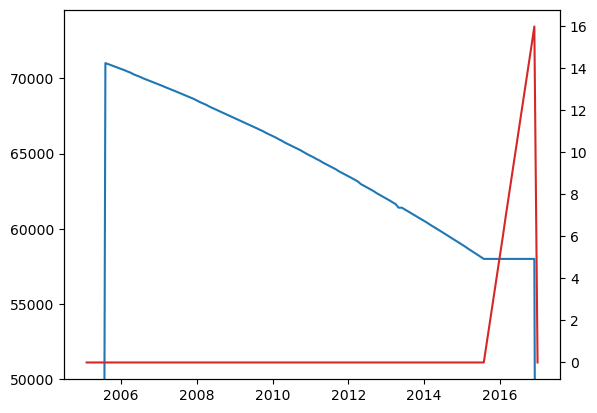

In [114]:
fig, ax = plt.subplots()

loan_id = 100312772807
x=df.loc[df.loan_identifier == loan_id]['time']
y=df.loc[df.loan_identifier == loan_id]['current_actual_upb']
y1=df.loc[df.loan_identifier == loan_id]['delinquency_status'].replace('XX', 0).astype(int)

ax.plot(x, y)
ax1 = ax.twinx()
ax1.plot(x, y1, color='tab:red')

ax.set_ylim(bottom=5e4)

plt.show()

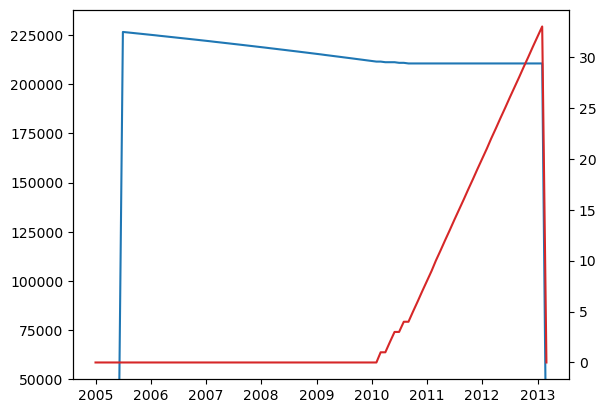

In [115]:
fig, ax = plt.subplots()

loan_id = 999154787202
x=df.loc[df.loan_identifier == loan_id]['time']
y=df.loc[df.loan_identifier == loan_id]['current_actual_upb']
y1=df.loc[df.loan_identifier == loan_id]['delinquency_status'].replace('XX', 0).astype(int)

ax.plot(x, y)
ax1 = ax.twinx()
ax1.plot(x, y1, color='tab:red')

ax.set_ylim(bottom=5e4)

plt.show()

<font size="6"> Deed-in-Lieu/REO disposition: ZB code = 9 </font>

In [151]:
df.loc[df.zero_balance_code == 9]['delinquency_status'].value_counts(dropna=False).sort_index().to_frame()

,count
delinquency_status,
06,2
07,6
08,1
09,1
10,2
11,2
12,1
13,2
14,3


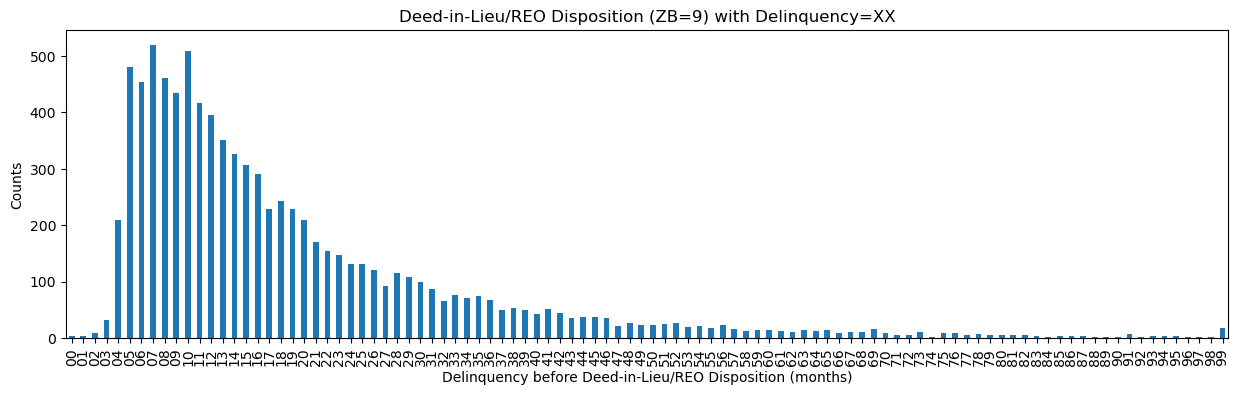

In [185]:
fig, ax= plt.subplots(figsize=(15, 4))
id_zb9_deliXX = df.loc[(df.zero_balance_code == 9) & (df.delinquency_status == 'XX')]['loan_identifier']
df.loc[df.loan_identifier.isin(id_zb9_deliXX)][['loan_identifier', 
                                            'time', 
                                            'zero_balance_code',  
                                            'delinquency_status', 
                                            'original_upb', 
                                            'current_actual_upb','zero_balance_effective_date', 'upb_at_the_time_of_removal']]\
.groupby('loan_identifier', as_index=False).nth(-2)['delinquency_status'].value_counts(dropna=False).sort_index().plot(kind='bar', ax=ax)
ax.set_ylabel('Counts')
ax.set_xlabel('Delinquency before Deed-in-Lieu/REO Disposition (months)')
ax.set_title('Deed-in-Lieu/REO Disposition (ZB=9) with Delinquency=XX')

plt.show()

<font size="6"> Non-Performing Note Sale: ZB code = 15 </font>

In [180]:
df.loc[df.zero_balance_code == 15]['delinquency_status'].value_counts(dropna=False).sort_index().to_frame()

,count
delinquency_status,
00,181
XX,677


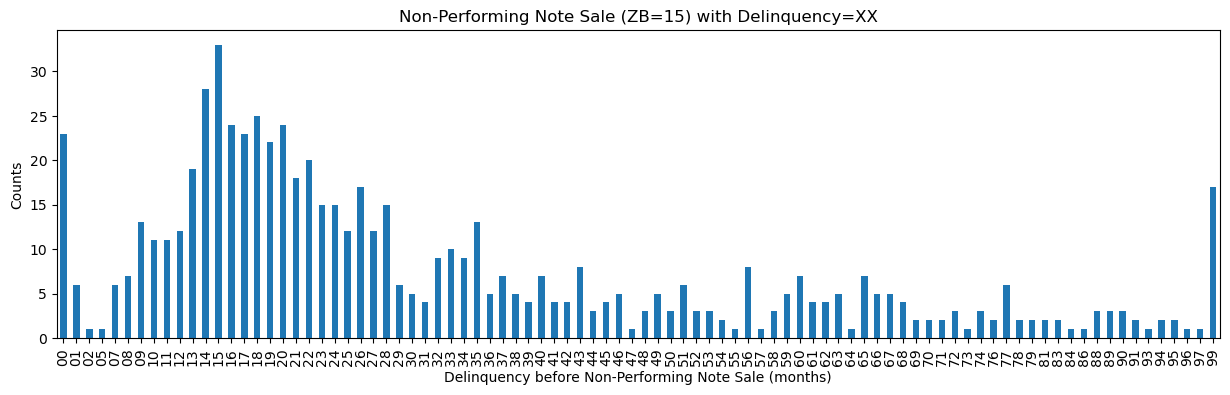

In [182]:
fig, ax= plt.subplots(figsize=(15, 4))
id_zb15_deliXX = df.loc[(df.zero_balance_code == 15) & (df.delinquency_status == 'XX')]['loan_identifier']
df.loc[df.loan_identifier.isin(id_zb15_deliXX)][['loan_identifier', 
                                            'time', 
                                            'zero_balance_code',  
                                            'delinquency_status', 
                                            'original_upb', 
                                            'current_actual_upb','zero_balance_effective_date', 'upb_at_the_time_of_removal']]\
.groupby('loan_identifier', as_index=False).nth(-2)['delinquency_status'].value_counts(dropna=False).sort_index().plot(kind='bar', ax=ax)
ax.set_ylabel('Counts')
ax.set_xlabel('Delinquency before Non-Performing Note Sale (months)')
ax.set_title('Non-Performing Note Sale (ZB=15) with Delinquency=XX')

plt.show()

<font size=6> REMINDER: make plots of zb code time-series </font>

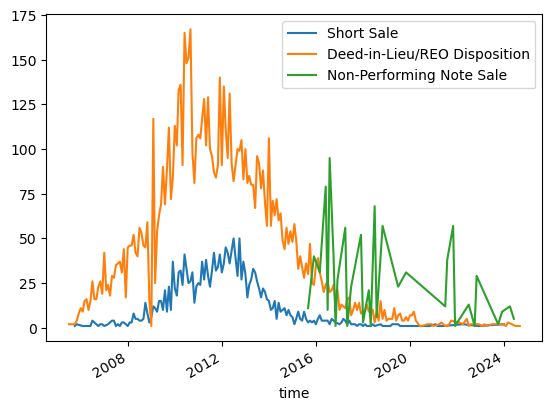

In [659]:
fig, ax = plt.subplots()

df.loc[df.zero_balance_code == 3].groupby('time').size().plot(ax=ax, label='Short Sale')
df.loc[df.zero_balance_code == 9].groupby('time').size().plot(ax=ax, label='Deed-in-Lieu/REO Disposition')
df.loc[df.zero_balance_code == 15].groupby('time').size().plot(ax=ax, label='Non-Performing Note Sale')
# df.loc[df.zero_balance_code.isin([3, 9, 15])].groupby('time').size().plot(ax=ax, label='Default ZB codes', color='grey')

ax.legend()

plt.show()

### Delinquency Status

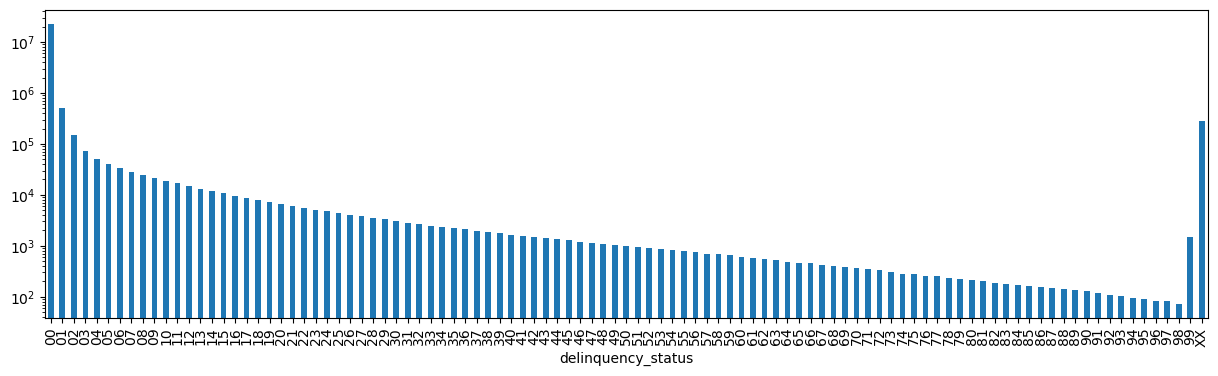

In [331]:
fig, ax = plt.subplots(figsize=(15, 4))

df.delinquency_status.value_counts(dropna=False).sort_index().plot(kind='bar', logy=True, ax=ax)

plt.show()

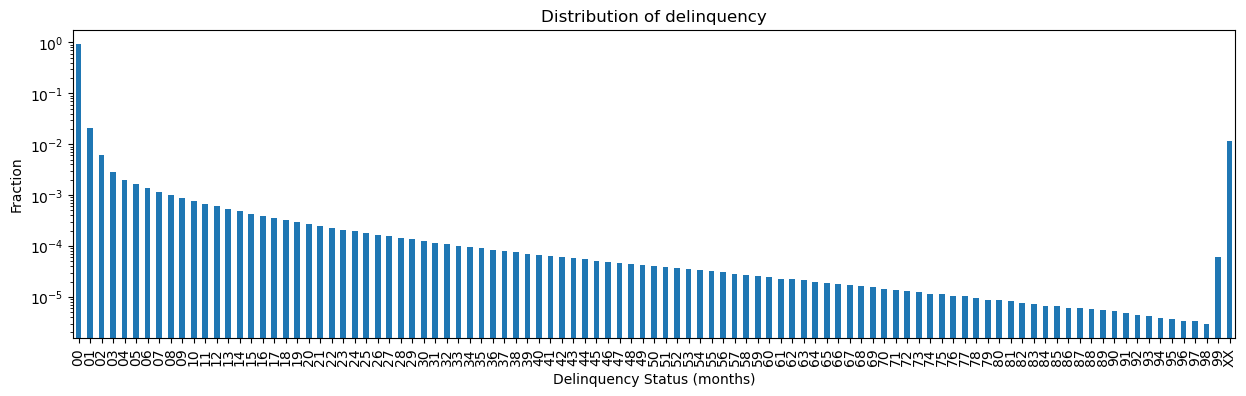

In [337]:
fig, ax = plt.subplots(figsize=(15, 4))

(df.delinquency_status.value_counts(dropna=False).sort_index()/len(df)).plot(kind='bar', logy=True, ax=ax)
ax.set_xlabel('Delinquency Status (months)')
ax.set_ylabel('Fraction')
ax.set_title('Distribution of delinquency')

plt.show()

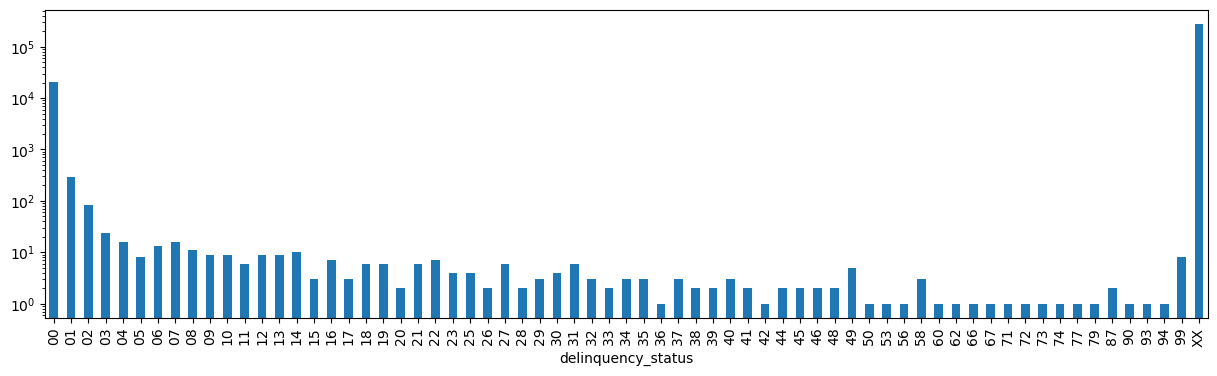

In [246]:
fig, ax = plt.subplots(figsize=(15, 4))

df.groupby('loan_identifier', as_index=False).last().delinquency_status.value_counts(dropna=False).sort_index().plot(kind='bar', logy=True, ax=ax)

plt.show()

In [226]:
df.loc[(df.delinquency_status == 'XX')].zero_balance_code.value_counts(dropna=False).sort_index()

zero_balance_code
1.0     268202
2.0       1139
3.0       2010
6.0        569
9.0       8804
15.0       677
16.0      1193
NaN         69
Name: count, dtype: int64

<font size=5> Delinquency status unknown (XX) and no zero balance code (nan) </font>

In [273]:
id_zbNaN_deliXX = df.loc[(df.delinquency_status == 'XX') & (~df.zero_balance_code.isin([1, 2, 3, 6, 9, 15, 16]))].loan_identifier.unique()

dfA = df.loc[df.loan_identifier.isin(id_zbNaN_deliXX)].groupby('loan_identifier', as_index=False).last()[['loan_identifier', 'time', 'delinquency_status', 'zero_balance_code']]#.zero_balance_code.value_counts(dropna=False).sort_index()
#.groupby(['delinquency_status', 'zero_balance_code']).size()
dfA

,loan_identifier,time,delinquency_status,zero_balance_code
0,101682024854,2017-07-01,XX,2.0
1,104374485722,2021-11-01,00,15.0
2,114050185852,2020-02-01,XX,9.0
3,122041729645,2017-10-01,XX,2.0
4,123486630181,2022-11-01,00,1.0
...,...,...,...,...
59,950397550669,2018-10-01,XX,2.0
60,955591826388,2020-11-01,00,16.0
61,964477905311,2018-10-01,XX,1.0
62,974515781580,2021-03-01,00,1.0


In [257]:
dfA.delinquency_status.value_counts(dropna=False).sort_index()

delinquency_status
00     8
58     1
79     1
99     2
XX    52
Name: count, dtype: int64

In [264]:
dfA.zero_balance_code.value_counts(dropna=False).sort_index()

zero_balance_code
1.0     11
2.0     16
6.0      1
9.0     29
15.0     3
16.0     3
NaN      1
Name: count, dtype: int64

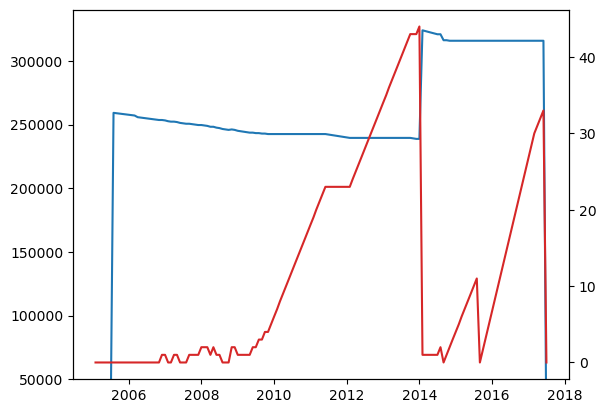

In [203]:
fig, ax = plt.subplots()

loan_id = 101682024854
x=df.loc[df.loan_identifier == loan_id]['time']
y=df.loc[df.loan_identifier == loan_id]['current_actual_upb']
y1=df.loc[df.loan_identifier == loan_id]['delinquency_status'].replace('XX', 0).astype(int)

ax.plot(x, y)
ax1 = ax.twinx()
ax1.plot(x, y1, color='tab:red')

ax.set_ylim(bottom=5e4)

plt.show()

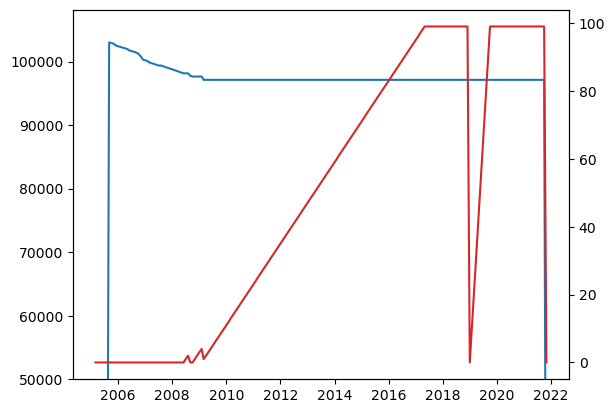

In [209]:
fig, ax = plt.subplots()

loan_id = 104374485722
x=df.loc[df.loan_identifier == loan_id]['time']
y=df.loc[df.loan_identifier == loan_id]['current_actual_upb']
y1=df.loc[df.loan_identifier == loan_id]['delinquency_status'].replace('XX', 0).astype(int)

ax.plot(x, y)
ax1 = ax.twinx()
ax1.plot(x, y1, color='tab:red')

ax.set_ylim(bottom=5e4)

plt.show()

### Handle XX

<font size=5> Conclusion: Remove loans with delinquency status unknown (XX) and no zero balance code (nan) </font>

In [637]:
%%time
# This is included in the prepocessing

# Remove loans with delinquency status unknown (XX) and no zero balance code (nan)
id_zbNaN_deliXX = df.loc[(df.delinquency_status == 'XX') & (df.zero_balance_code.isna())].loan_identifier.unique()
df.drop(df.loc[df['loan_identifier'].isin(id_zbNaN_deliXX)].index, inplace=True)

CPU times: user 2.75 s, sys: 912 ms, total: 3.67 s
Wall time: 3.75 s


<font size=5> Replace 'XX' with previous delinquency status + 1 </font>

In [638]:
%%time
# This is included in the prepocessing

# Replace 'XX' with previous delinquency status + 1
df = replaceXX(df)

CPU times: user 17.7 s, sys: 2.17 s, total: 19.9 s
Wall time: 20.3 s


In [370]:
# Sample DataFrame
df = pd.DataFrame({
    'time':[1, 2, 3, 1, 2, 3, 1],
    'loan_id': [1, 1, 1, 2, 2, 2, 3],
    'delinquency_status': ['0', '1', 'XX', '2', '3', 'XX', 'XX']
})

# display(df)

# Convert 'XX' to NaN (to use ffill)
df['delinquency_status'] = pd.to_numeric(df['delinquency_status'], errors='coerce')
print('Step 1')
display(df)

# Vectorized forward fill within each loan_id group
mask = df['delinquency_status'].isna()
df.sort_values(['loan_id', 'time'], inplace=True)  # Ensure correct order per loan_id
df['delinquency_status'] = df.groupby('loan_id')['delinquency_status'].ffill().fillna(0)
print('Step 2')
display(df)

# Increment the 'XX' (previously NaN) values by 1
df.loc[mask, 'delinquency_status'] = df.loc[mask, 'delinquency_status']+1
print('Step 3')
display(df)

Step 1


,time,loan_id,delinquency_status
0,1,1,0.0
1,2,1,1.0
2,3,1,NaN
3,1,2,2.0
4,2,2,3.0
5,3,2,NaN
6,1,3,NaN


Step 2


,time,loan_id,delinquency_status
0,1,1,0.0
1,2,1,1.0
2,3,1,1.0
3,1,2,2.0
4,2,2,3.0
5,3,2,3.0
6,1,3,0.0


Step 3


,time,loan_id,delinquency_status
0,1,1,0.0
1,2,1,1.0
2,3,1,2.0
3,1,2,2.0
4,2,2,3.0
5,3,2,4.0
6,1,3,1.0


In [556]:
def replaceXX(df):
    
    # Convert 'XX' to NaN (to use ffill)
    df['delinquency_status'] = pd.to_numeric(df['delinquency_status'], errors='coerce')
    
    # Vectorized forward fill within each loan_id group
    mask = df['delinquency_status'].isna()
    df.sort_values(['loan_identifier', 'time'], inplace=True)  # Ensure correct order per loan_id
    df['delinquency_status'] = df.groupby('loan_identifier')['delinquency_status'].ffill().fillna(0)
    
    # Increment the 'XX' (previously NaN) values by 1
    df.loc[mask, 'delinquency_status'] = df.loc[mask, 'delinquency_status']+1
    df['delinquency_status'] = df['delinquency_status'].astype(int)
    df.sort_values('time', inplace=True) # ----------> Maybe remove this

    return df
    

In [557]:
# Sample DataFrame
df_test = pd.DataFrame({
    'time':[1, 3, 2, 1, 2, 3, 1],
    'loan_identifier': [1, 1, 1, 2, 2, 2, 3],
    'delinquency_status': ['0', 'XX', '1', '2', '3', 'XX', 'XX']
})
display(df_test)
replaceXX(df_test)
display(df_test)

,time,loan_identifier,delinquency_status
0,1,1,0
1,3,1,XX
2,2,1,1
3,1,2,2
4,2,2,3
5,3,2,XX
6,1,3,XX


,time,loan_identifier,delinquency_status
0,1,1,0
3,1,2,2
6,1,3,1
2,2,1,1
4,2,2,3
1,3,1,2
5,3,2,4


In [558]:
xxids = df.loc[(df.delinquency_status == 'XX') & (df.zero_balance_code == 15)]['loan_identifier'].unique()
dfA = df.loc[df.loan_identifier.isin(xxids)].copy()
dfA

,loan_identifier,time,year,channel,original_interest_rate,current_interest_rate,original_upb,current_actual_upb,original_loan_term,loan_age,...,upb_at_the_time_of_removal,total_principal_current,last_paid_installment_date,foreclosure_date,special_eligibility_program,property_valuation_method,high_balance_loan_indicator,borrower_assistance_plan,alternative_delinquency_resolution,alternative_delinquency_resolution_count
5926,100213557668,2005-01-01,2005,B,5.375,5.375,122000.0,0.00,180,0.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN
5927,100213557668,2005-02-01,2005,B,5.375,5.375,122000.0,0.00,180,1.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN
5928,100213557668,2005-03-01,2005,B,5.375,5.375,122000.0,0.00,180,2.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN
5929,100213557668,2005-04-01,2005,B,5.375,5.375,122000.0,0.00,180,3.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN
5930,100213557668,2005-05-01,2005,B,5.375,5.375,122000.0,0.00,180,4.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24540574,999220746282,2016-04-01,2016,B,5.500,4.500,176000.0,172945.42,360,134.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN
24540575,999220746282,2016-05-01,2016,B,5.500,4.500,176000.0,172945.42,360,135.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN
24540576,999220746282,2016-06-01,2016,B,5.500,4.500,176000.0,172945.42,360,136.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN
24540577,999220746282,2016-07-01,2016,B,5.500,4.500,176000.0,172945.42,360,137.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN


In [563]:
dfB = dfA.groupby('loan_identifier').nth(-2)[['loan_identifier', 'time', 'delinquency_status', 'zero_balance_code']]
dfC = dfA.loc[dfA.loan_identifier.isin(dfB.loc[dfB.delinquency_status.isin(['99', '00'])].loan_identifier.unique()[:4])].copy()

In [564]:
dfC.groupby('loan_identifier').tail(2)[['loan_identifier', 'time', 'delinquency_status', 'zero_balance_code']]#.sort_values(by=['loan_identifier', 'time'])

,loan_identifier,time,delinquency_status,zero_balance_code
213995,107719526284,2016-09-01,99,NaN
213996,107719526284,2016-10-01,XX,15.0
1645438,159693686121,2017-06-01,00,NaN
1645439,159693686121,2017-07-01,XX,15.0
2131932,177375143326,2019-10-01,00,NaN
2131933,177375143326,2019-11-01,XX,15.0
2158114,178439554429,2017-03-01,00,NaN
2158115,178439554429,2017-04-01,XX,15.0


In [562]:
dfC.groupby('loan_identifier').tail(2)[['loan_identifier', 'time', 'delinquency_status', 'zero_balance_code']].sort_values(by=['loan_identifier', 'time'])

,loan_identifier,time,delinquency_status,zero_balance_code
213995,107719526284,2016-09-01,99,NaN
213996,107719526284,2016-10-01,100,15.0
1645438,159693686121,2017-06-01,0,NaN
1645439,159693686121,2017-07-01,1,15.0
2131932,177375143326,2019-10-01,0,NaN
2131933,177375143326,2019-11-01,1,15.0
2158114,178439554429,2017-03-01,0,NaN
2158115,178439554429,2017-04-01,1,15.0


In [561]:
dfC = replaceXX(dfC)

In [546]:
numXX = df.loc[(df.delinquency_status == 'XX') & (df.zero_balance_code.isna())].groupby('loan_identifier').size()

In [511]:
numXX = df.loc[(df.delinquency_status == 'XX')].groupby('loan_identifier').size()

In [551]:
numXX

loan_identifier
101682024854    1
104374485722    1
114050185852    1
122041729645    1
123486630181    1
               ..
950397550669    1
955591826388    1
964477905311    1
974515781580    1
999747352775    1
Length: 64, dtype: int64

In [533]:
len(id_zbNaN_deliXX)

64

In [549]:
len(np.isin(id_zbNaN_deliXX, numXX[numXX > 1].index))

64

In [550]:
numXX[numXX > 1].index

Index([124439410821, 167586058303, 498269724083, 548300249397, 763768185879], dtype='int64', name='loan_identifier')

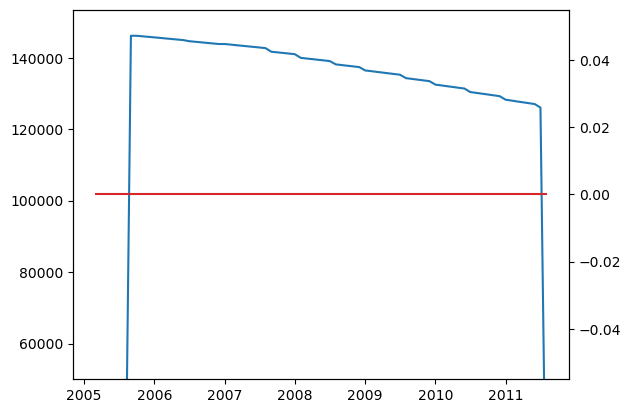

In [555]:
fig, ax = plt.subplots()

loan_id = 763768185879
x=df.loc[df.loan_identifier == loan_id]['time']
y=df.loc[df.loan_identifier == loan_id]['current_actual_upb']
y1=df.loc[df.loan_identifier == loan_id]['delinquency_status'].replace('XX', 0).astype(int)

ax.plot(x, y)
ax1 = ax.twinx()
ax1.plot(x, y1, color='tab:red')

ax.set_ylim(bottom=5e4)

plt.show()

<Axes: xlabel='delinquency_status'>

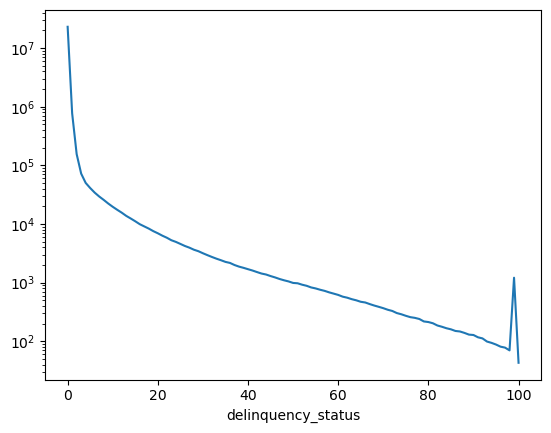

In [571]:
df.delinquency_status.value_counts(dropna=False).sort_index().plot(logy=True)

In [444]:
def plot_delinquency(df, threshold=None, ax=None, label=None):
    df.loc[df.delinquency_status >= threshold].groupby('time').size().plot(ax=ax, label=label)

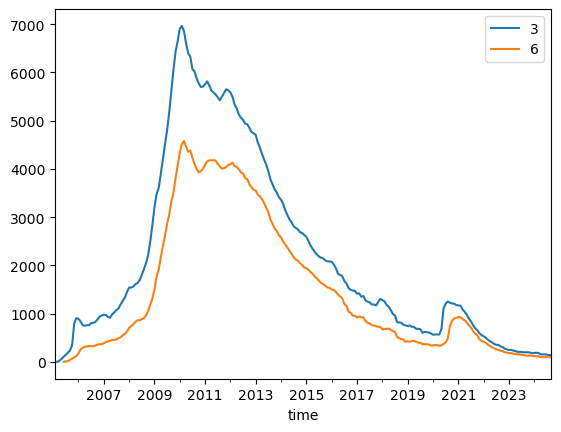

In [581]:
fig, ax = plt.subplots()

plot_delinquency(df, threshold=3, ax=ax, label='3')
plot_delinquency(df, threshold=6, ax=ax, label='6')
ax.legend()

plt.show()

In [600]:
len(df.loc[(df.delinquency_status >= 6) | (df.zero_balance_code.isin([3, 9, 15]))]) - len(df.loc[(df.delinquency_status >= 6)])

781

### Default Target

In [19]:
def define_default(df: pd.DataFrame, delinquency_threshold: int=None, pred_tw: int=None) -> pd.DataFrame:

    # Step 1: Identify the first month each loan defaults (delinquency_status >= 6)
    df['default_flag'] = ((df['delinquency_status'] >= delinquency_threshold) | (df['zero_balance_code'].isin([3, 9, 15])))
    
    # Step 2: Separate default from non-default loans
    default_loans = df.loc[df['default_flag'] == True]['loan_identifier'].unique()
    df_non_default_loans = df[~df['loan_identifier'].isin(default_loans)]
    df = df.loc[df['loan_identifier'].isin(default_loans)]

    # Step 3: Find the first default month per loan
    first_default_time = df[df['default_flag']].groupby('loan_identifier')['time'].min().rename('default_time')

    # Step 4: Merge this info back to the main dataframe
    df = df.merge(first_default_time, on='loan_identifier', how='left')
    df['default_time'] = df['default_time'].fillna(pd.NaT)

    # Step 5: Create an irreversible default flag (1 if loan has defaulted, 0 otherwise)
    df['default'] = (df['time'] >= df['default_time']).astype(int)

    # Step 6: Keep only records **before** or **at** the first default event
    df = df[df['time'] <= df['default_time']].copy()

    # Step 7: Create a target variable for PD (whether the loan will default in the next N month time window – pred_tw)
    df['time_offset_to_default'] = df['default_time'] - pd.DateOffset(months=pred_tw)
    df['pd_target'] = (df['time'] >= df['time_offset_to_default']).astype(int)
    
    # Step 8: Append non-default loans
    df = pd.concat([df, df_non_default_loans])
    df['default'] = df['default'].fillna(0)
    df['pd_target'] = df['pd_target'].fillna(0)
    
    df.drop(['default_flag', 'default_time'], axis=1, inplace=True)
    df.sort_values('time', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [20]:
%%time
# Default 
dfD3t1 = define_default(df, delinquency_threshold=3, pred_tw=1)

CPU times: user 7.87 s, sys: 6.13 s, total: 14 s
Wall time: 16.3 s


In [21]:
%%time
# Default 
dfD3t3 = define_default(df, delinquency_threshold=3, pred_tw=3)

CPU times: user 7.82 s, sys: 6.85 s, total: 14.7 s
Wall time: 17.2 s


In [22]:
%%time
# Default 
dfD3t6 = define_default(df, delinquency_threshold=3, pred_tw=6)

CPU times: user 7.85 s, sys: 7.2 s, total: 15 s
Wall time: 17.6 s


In [23]:
%%time
# Default 
dfD6t1 = define_default(df, delinquency_threshold=6, pred_tw=1)

CPU times: user 7.97 s, sys: 7.38 s, total: 15.3 s
Wall time: 18.1 s


In [24]:
%%time
# Default 
dfD6t3 = define_default(df, delinquency_threshold=6, pred_tw=3)

CPU times: user 7.98 s, sys: 7.53 s, total: 15.5 s
Wall time: 18.2 s


In [25]:
%%time
# Default 
dfD6t6 = define_default(df, delinquency_threshold=6, pred_tw=6)

CPU times: user 8 s, sys: 7.48 s, total: 15.5 s
Wall time: 18.3 s


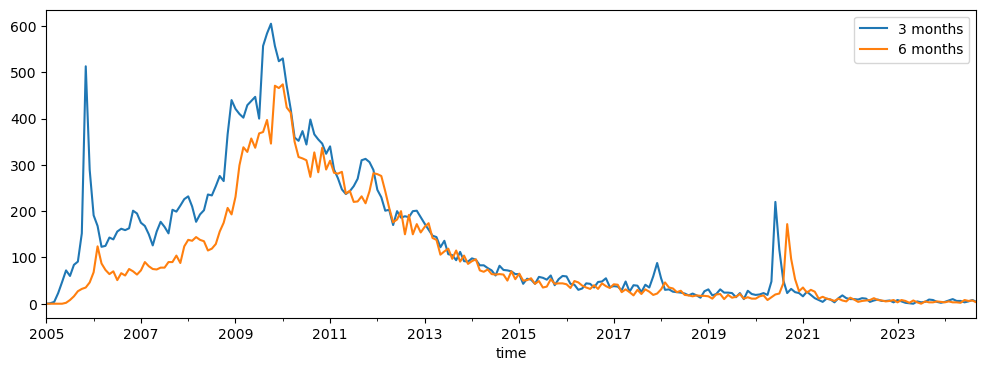

In [125]:
fig, ax = plt.subplots(figsize=(12, 4))

dfD3t1.groupby('time')['default'].sum().plot(ax=ax, label='3 months')
dfD6t1.groupby('time')['default'].sum().plot(ax=ax, label='6 months')

ax.legend()
# ax.set_xticks(dfD.time)

plt.show()

In [72]:
%%time
dtset = dfD3t1
default_loans = dtset.loc[dtset.default == 1]['loan_identifier'].unique()
non_default_loans = list(set(list(dtset['loan_identifier'].unique())) - set(list(default_loans)))

CPU times: user 253 ms, sys: 18.5 ms, total: 272 ms
Wall time: 271 ms


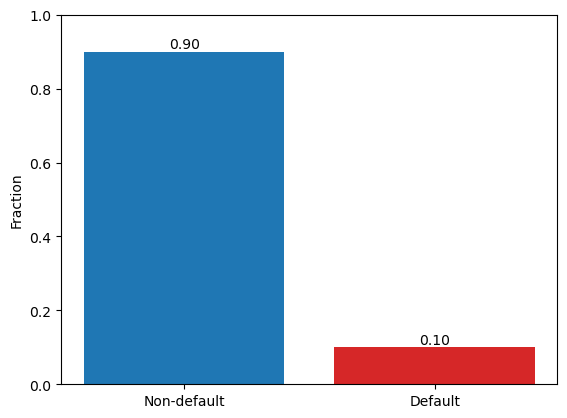

In [73]:
fig, ax = plt.subplots()

N = dtset.loan_identifier.nunique()
b = ax.bar(x=['Non-default', 'Default'], height=[len(non_default_loans)/N, len(default_loans)/N], color=['C0', 'C3'], label=[10, 20])
ax.bar_label(b, fmt='%.2f')

ax.set_ylim(top=1)
# ax.set_title('Class Imbalance')
ax.set_ylabel('Fraction')

plt.show()

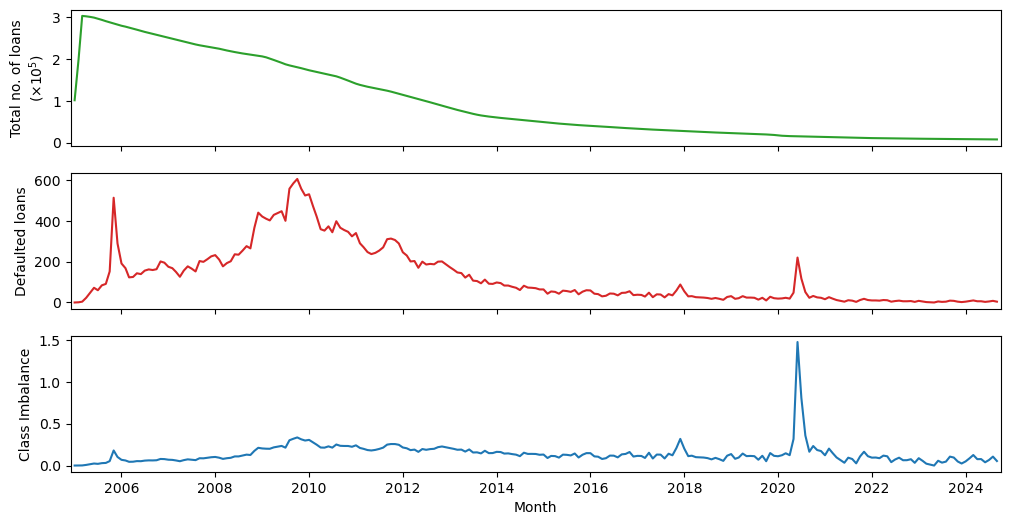

In [74]:
fig, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

dtset = dfD3t1
# Total number of loans
y = dtset.groupby('time').size()
x = y.index
ax[0].plot(x, y/1e5, color='C2')


# Defult count
y = dtset.groupby('time')['default'].sum()
x = y.index
ax[1].plot(x, y, color='C3')

# Class imbalance
y = 100*dtset.groupby('time')['default'].sum()/dtset.groupby('time')['loan_identifier'].size()
x = y.index
ax[2].plot(x, y)

ax[0].set_ylabel('Total no. of loans\n'+r'($\times 10^{5}$)')
ax[0].set_xlabel('')

ax[1].set_ylabel('Defaulted loans')
ax[1].set_xlabel('')

ax[2].set_ylabel('Class Imbalance')
ax[2].set_xlabel('Month')
ax[2].set_xticks([i for i in x if (i.month == 1 and i.year % 2 ==0)], [f'{i.year}' for i in x if (i.month == 1 and i.year % 2 ==0)])
ax[2].set_xlim(left=x.min()-pd.Timedelta('30D'), right=x.max()+pd.Timedelta('30D'))

plt.show()

In [209]:
dfA = df.loc[df.loan_identifier.isin(np.concat([default_loans[1:2], non_default_loans[:1]]))]\
[['loan_identifier', 'time', 'delinquency_status', 'zero_balance_code']]

In [236]:
default_loans[0]

np.int64(305909545974)

In [238]:
i=0

152


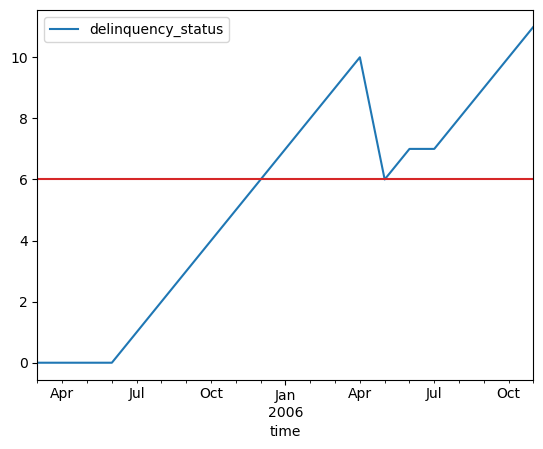

In [437]:
fig, ax = plt.subplots()

print(i)
df.loc[df.loan_identifier == default_loans[i]].plot(x='time', y='delinquency_status', ax=ax)
ax.axhline(y=6, color='tab:red')
i+=1

<Axes: xlabel='time'>

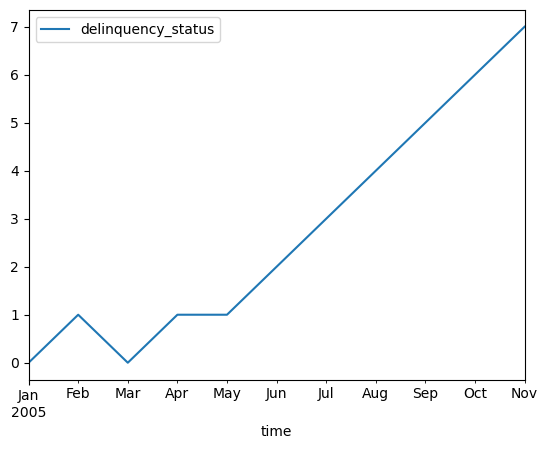

In [325]:
fig, ax = plt.subplots()

df.loc[df.loan_identifier == default_loans[70]].plot(x='time', y='delinquency_status', ax=ax)

<Axes: xlabel='time'>

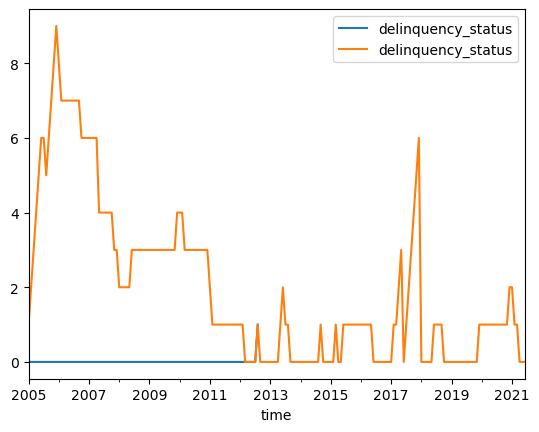

In [210]:
fig, ax = plt.subplots()
dfA.loc[df.loan_identifier.isin(non_default_loans)].plot(x='time', y='delinquency_status', ax=ax)
dfA.loc[df.loan_identifier.isin(default_loans)].plot(x='time', y='delinquency_status', ax=ax)

In [87]:
df.loc[df.loan_identifier == 353449634239][['loan_identifier', 'time', 'delinquency_status', 'zero_balance_code', 'default', 'pd_target']]

,loan_identifier,time,delinquency_status,zero_balance_code,default,target_default
99347,353449634239,2005-01-01,1,NaN,0.0,0.0
262215,353449634239,2005-02-01,2,NaN,0.0,0.0
599215,353449634239,2005-03-01,3,NaN,0.0,0.0
765772,353449634239,2005-04-01,4,NaN,0.0,0.0
939153,353449634239,2005-05-01,5,NaN,0.0,0.0
1406605,353449634239,2005-06-01,6,NaN,1.0,1.0


In [359]:
default_loans = df.loc[df.default == 1]['loan_identifier'].unique()
df.loc[df['loan_identifier'].isin(default_loans)].groupby('loan_identifier').size()\
      [df.loc[df['loan_identifier'].isin(default_loans)].groupby('loan_identifier').size() == 4 ]

loan_identifier
102670585358    4
152370562188    4
156351451834    4
163401300221    4
163426502179    4
               ..
892427758156    4
896068239155    4
910505243111    4
947730089114    4
998567108190    4
Length: 69, dtype: int64

In [360]:
dfB.loc[dfB.loan_identifier == 102670585358][['loan_identifier', 'time', 'delinquency_status', 'default', 'pd_target']]

,loan_identifier,time,delinquency_status,default,pd_target
261560,102670585358,2005-02-01,0,0.0,1.0
519977,102670585358,2005-03-01,0,0.0,1.0
809160,102670585358,2005-04-01,2,0.0,1.0
1038860,102670585358,2005-05-01,3,1.0,1.0


In [347]:
%%time
# Default of the whole dataset
df = define_default(df, delinquency_threshold=3, pred_tw=6)

Step 1: Identify the first month each loan defaults (delinquency_status >= 6)


,loan_identifier,time,delinquency_status,default_flag
75613,102675572648,2005-03-01,0,False
75614,102675572648,2005-04-01,0,False
75615,102675572648,2005-05-01,0,False
75616,102675572648,2005-06-01,0,False
75617,102675572648,2005-07-01,0,False
...,...,...,...,...
75677,102675572648,2010-07-01,60,True
75678,102675572648,2010-08-01,61,True
75679,102675572648,2010-09-01,62,True
75680,102675572648,2010-10-01,63,True


Step 2: Separate default from non-default loans


,loan_identifier,time,delinquency_status,default_flag
75613,102675572648,2005-03-01,0,False
75614,102675572648,2005-04-01,0,False
75615,102675572648,2005-05-01,0,False
75616,102675572648,2005-06-01,0,False
75617,102675572648,2005-07-01,0,False
...,...,...,...,...
75677,102675572648,2010-07-01,60,True
75678,102675572648,2010-08-01,61,True
75679,102675572648,2010-09-01,62,True
75680,102675572648,2010-10-01,63,True


Index(['loan_identifier', 'time', 'year', 'channel', 'original_interest_rate',
       'current_interest_rate', 'original_upb', 'current_actual_upb',
       'original_loan_term', 'loan_age', 'remaining_months_to_maturity', 'ltv',
       'cltv', 'number_of_borrowers', 'dti',
       'borrower_credit_score_at_origination',
       'co_borrower_credit_score_at_origination',
       'first_time_home_buyer_indicator', 'loan_purpose', 'property_type',
       'number_of_units', 'occupancy_status', 'property_state',
       'metropolitan_statistical_area_(msa)', 'zip_code_short',
       'mortgage_insurance_percentage', 'amortization_type',
       'prepayment_penalty_indicator', 'interest_only_loan_indicator',
       'interest_only_first_principal_and_interest_payment_date',
       'months_to_amortization', 'delinquency_status', 'zero_balance_code',
       'zero_balance_effective_date', 'upb_at_the_time_of_removal',
       'total_principal_current', 'last_paid_installment_date',
       'foreclosure_

,loan_identifier,time,delinquency_status,default_flag,default_time
57683,102675572648,2005-03-01,0,False,2005-10-01
82694,102675572648,2005-04-01,0,False,2005-10-01
112756,102675572648,2005-05-01,0,False,2005-10-01
135918,102675572648,2005-06-01,0,False,2005-10-01
180370,102675572648,2005-07-01,0,False,2005-10-01
...,...,...,...,...,...
1836882,102675572648,2010-07-01,60,True,2005-10-01
1866424,102675572648,2010-08-01,61,True,2005-10-01
1885693,102675572648,2010-09-01,62,True,2005-10-01
1929928,102675572648,2010-10-01,63,True,2005-10-01


Step 5: Create an irreversible default flag (1 if loan has defaulted, 0 otherwise)


,loan_identifier,time,delinquency_status,default_flag,default_time,default
57683,102675572648,2005-03-01,0,False,2005-10-01,0
82694,102675572648,2005-04-01,0,False,2005-10-01,0
112756,102675572648,2005-05-01,0,False,2005-10-01,0
135918,102675572648,2005-06-01,0,False,2005-10-01,0
180370,102675572648,2005-07-01,0,False,2005-10-01,0
...,...,...,...,...,...,...
1836882,102675572648,2010-07-01,60,True,2005-10-01,1
1866424,102675572648,2010-08-01,61,True,2005-10-01,1
1885693,102675572648,2010-09-01,62,True,2005-10-01,1
1929928,102675572648,2010-10-01,63,True,2005-10-01,1


Step 6: Keep only records **before** or **at** the first default event


,loan_identifier,time,delinquency_status,default_flag,default_time,default
57683,102675572648,2005-03-01,0,False,2005-10-01,0
82694,102675572648,2005-04-01,0,False,2005-10-01,0
112756,102675572648,2005-05-01,0,False,2005-10-01,0
135918,102675572648,2005-06-01,0,False,2005-10-01,0
180370,102675572648,2005-07-01,0,False,2005-10-01,0
196352,102675572648,2005-08-01,1,False,2005-10-01,0
222997,102675572648,2005-09-01,2,False,2005-10-01,0
247977,102675572648,2005-10-01,3,True,2005-10-01,1


Step 7.1: Create a target variable for PD (whether the loan will default in the next N month time window – pred_tw)


,loan_identifier,time,delinquency_status,default_flag,default_time,default,time_offset_to_default,pd_target
57683,102675572648,2005-03-01,0,False,2005-10-01,0,2005-04-01,0
82694,102675572648,2005-04-01,0,False,2005-10-01,0,2005-04-01,1
112756,102675572648,2005-05-01,0,False,2005-10-01,0,2005-04-01,1
135918,102675572648,2005-06-01,0,False,2005-10-01,0,2005-04-01,1
180370,102675572648,2005-07-01,0,False,2005-10-01,0,2005-04-01,1
196352,102675572648,2005-08-01,1,False,2005-10-01,0,2005-04-01,1
222997,102675572648,2005-09-01,2,False,2005-10-01,0,2005-04-01,1
247977,102675572648,2005-10-01,3,True,2005-10-01,1,2005-04-01,1


Step 8: Append non-default loans


,loan_identifier,time,delinquency_status,default_flag,default_time,default,pd_target
57683,102675572648,2005-03-01,0,False,2005-10-01,0.0,0.0
82694,102675572648,2005-04-01,0,False,2005-10-01,0.0,1.0
112756,102675572648,2005-05-01,0,False,2005-10-01,0.0,1.0
135918,102675572648,2005-06-01,0,False,2005-10-01,0.0,1.0
180370,102675572648,2005-07-01,0,False,2005-10-01,0.0,1.0
196352,102675572648,2005-08-01,1,False,2005-10-01,0.0,1.0
222997,102675572648,2005-09-01,2,False,2005-10-01,0.0,1.0
247977,102675572648,2005-10-01,3,True,2005-10-01,1.0,1.0


End


,loan_identifier,time,delinquency_status,default,pd_target
519360,102675572648,2005-03-01,0,0.0,0.0
808414,102675572648,2005-04-01,0,0.0,1.0
1043833,102675572648,2005-05-01,0,0.0,1.0
1301065,102675572648,2005-06-01,0,0.0,1.0
1614852,102675572648,2005-07-01,0,0.0,1.0
2030812,102675572648,2005-08-01,1,0.0,1.0
2193371,102675572648,2005-09-01,2,0.0,1.0
2461102,102675572648,2005-10-01,3,1.0,1.0


CPU times: user 11.7 s, sys: 9.45 s, total: 21.2 s
Wall time: 24.7 s


In [344]:
%%time
# Default of the whole dataset
dfB = define_default(df[['loan_identifier', 'time', 'delinquency_status', 'zero_balance_code']].copy(), delinquency_threshold=3, pred_tw=6)


Step 1: Identify the first month each loan defaults (delinquency_status >= 6)


,loan_identifier,time,delinquency_status,default_flag
75613,102675572648,2005-03-01,0,False
75614,102675572648,2005-04-01,0,False
75615,102675572648,2005-05-01,0,False
75616,102675572648,2005-06-01,0,False
75617,102675572648,2005-07-01,0,False
...,...,...,...,...
75677,102675572648,2010-07-01,60,True
75678,102675572648,2010-08-01,61,True
75679,102675572648,2010-09-01,62,True
75680,102675572648,2010-10-01,63,True


Step 2: Separate default from non-default loans


,loan_identifier,time,delinquency_status,default_flag
75613,102675572648,2005-03-01,0,False
75614,102675572648,2005-04-01,0,False
75615,102675572648,2005-05-01,0,False
75616,102675572648,2005-06-01,0,False
75617,102675572648,2005-07-01,0,False
...,...,...,...,...
75677,102675572648,2010-07-01,60,True
75678,102675572648,2010-08-01,61,True
75679,102675572648,2010-09-01,62,True
75680,102675572648,2010-10-01,63,True


Index(['loan_identifier', 'time', 'delinquency_status', 'zero_balance_code',
       'default_flag', 'default_time'],
      dtype='object')
Step 4: Merge this info back to the main dataframe


,loan_identifier,time,delinquency_status,default_flag,default_time
57683,102675572648,2005-03-01,0,False,2005-10-01
82694,102675572648,2005-04-01,0,False,2005-10-01
112756,102675572648,2005-05-01,0,False,2005-10-01
135918,102675572648,2005-06-01,0,False,2005-10-01
180370,102675572648,2005-07-01,0,False,2005-10-01
...,...,...,...,...,...
1836882,102675572648,2010-07-01,60,True,2005-10-01
1866424,102675572648,2010-08-01,61,True,2005-10-01
1885693,102675572648,2010-09-01,62,True,2005-10-01
1929928,102675572648,2010-10-01,63,True,2005-10-01


Step 5: Create an irreversible default flag (1 if loan has defaulted, 0 otherwise)


,loan_identifier,time,delinquency_status,default_flag,default_time,default
57683,102675572648,2005-03-01,0,False,2005-10-01,0
82694,102675572648,2005-04-01,0,False,2005-10-01,0
112756,102675572648,2005-05-01,0,False,2005-10-01,0
135918,102675572648,2005-06-01,0,False,2005-10-01,0
180370,102675572648,2005-07-01,0,False,2005-10-01,0
...,...,...,...,...,...,...
1836882,102675572648,2010-07-01,60,True,2005-10-01,1
1866424,102675572648,2010-08-01,61,True,2005-10-01,1
1885693,102675572648,2010-09-01,62,True,2005-10-01,1
1929928,102675572648,2010-10-01,63,True,2005-10-01,1


Step 6: Keep only records **before** or **at** the first default event


,loan_identifier,time,delinquency_status,default_flag,default_time,default
57683,102675572648,2005-03-01,0,False,2005-10-01,0
82694,102675572648,2005-04-01,0,False,2005-10-01,0
112756,102675572648,2005-05-01,0,False,2005-10-01,0
135918,102675572648,2005-06-01,0,False,2005-10-01,0
180370,102675572648,2005-07-01,0,False,2005-10-01,0
196352,102675572648,2005-08-01,1,False,2005-10-01,0
222997,102675572648,2005-09-01,2,False,2005-10-01,0
247977,102675572648,2005-10-01,3,True,2005-10-01,1


Step 7.1: Create a target variable for PD (whether the loan will default in the next N month time window – pred_tw)


,loan_identifier,time,delinquency_status,default_flag,default_time,default,time_offset_to_default,pd_target
57683,102675572648,2005-03-01,0,False,2005-10-01,0,2005-04-01,0
82694,102675572648,2005-04-01,0,False,2005-10-01,0,2005-04-01,1
112756,102675572648,2005-05-01,0,False,2005-10-01,0,2005-04-01,1
135918,102675572648,2005-06-01,0,False,2005-10-01,0,2005-04-01,1
180370,102675572648,2005-07-01,0,False,2005-10-01,0,2005-04-01,1
196352,102675572648,2005-08-01,1,False,2005-10-01,0,2005-04-01,1
222997,102675572648,2005-09-01,2,False,2005-10-01,0,2005-04-01,1
247977,102675572648,2005-10-01,3,True,2005-10-01,1,2005-04-01,1


Step 8: Append non-default loans


,loan_identifier,time,delinquency_status,default_flag,default_time,default,pd_target
57683,102675572648,2005-03-01,0,False,2005-10-01,0.0,0.0
82694,102675572648,2005-04-01,0,False,2005-10-01,0.0,1.0
112756,102675572648,2005-05-01,0,False,2005-10-01,0.0,1.0
135918,102675572648,2005-06-01,0,False,2005-10-01,0.0,1.0
180370,102675572648,2005-07-01,0,False,2005-10-01,0.0,1.0
196352,102675572648,2005-08-01,1,False,2005-10-01,0.0,1.0
222997,102675572648,2005-09-01,2,False,2005-10-01,0.0,1.0
247977,102675572648,2005-10-01,3,True,2005-10-01,1.0,1.0


End


,loan_identifier,time,delinquency_status,default,pd_target
519360,102675572648,2005-03-01,0,0.0,0.0
808414,102675572648,2005-04-01,0,0.0,1.0
1043833,102675572648,2005-05-01,0,0.0,1.0
1301065,102675572648,2005-06-01,0,0.0,1.0
1614852,102675572648,2005-07-01,0,0.0,1.0
2030812,102675572648,2005-08-01,1,0.0,1.0
2193371,102675572648,2005-09-01,2,0.0,1.0
2461102,102675572648,2005-10-01,3,1.0,1.0


CPU times: user 4.29 s, sys: 1.02 s, total: 5.31 s
Wall time: 5.32 s


In [369]:
%%time
dfA = df.loc[df.loan_identifier == 102923731410][['loan_identifier', 'time', 'delinquency_status', 'zero_balance_code']]
dfA = define_default(dfA, delinquency_threshold=3, pred_tw=4)
# dfA.sort_values(['loan_identifier', 'time']).tail(10)
dfA

Index(['loan_identifier', 'time', 'delinquency_status', 'zero_balance_code',
       'default_flag', 'default_time'],
      dtype='object')
CPU times: user 21.7 ms, sys: 6.17 ms, total: 27.9 ms
Wall time: 25.8 ms


,loan_identifier,time,delinquency_status,zero_balance_code,default,time_offset_to_default,pd_target
0,102923731410,2005-01-01,0,NaN,0.0,2005-03-01,0.0
1,102923731410,2005-02-01,0,NaN,0.0,2005-03-01,0.0
2,102923731410,2005-03-01,0,NaN,0.0,2005-03-01,1.0
3,102923731410,2005-04-01,0,NaN,0.0,2005-03-01,1.0
4,102923731410,2005-05-01,1,NaN,0.0,2005-03-01,1.0
5,102923731410,2005-06-01,2,NaN,0.0,2005-03-01,1.0
6,102923731410,2005-07-01,3,NaN,1.0,2005-03-01,1.0


In [83]:
pd.date_range(start=pd.Timestamp(2005, 1, 1), end=pd.Timestamp(2005, 4, 1), freq='MS')

DatetimeIndex(['2005-01-01', '2005-02-01', '2005-03-01', '2005-04-01'], dtype='datetime64[ns]', freq='MS')

In [1042]:
# Sample dataset (Replace with your actual data)
data = {
    'loan_identifier':    [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 5],
    'time':               [1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 6, 1, 2, 3, 1, 2, 1, 2, 3],
    'delinquency_status': [2, 4, 6, 5, 3, 4, 5, 5, 6, 7, 8, 0, 1, 2, 5, 6, 7, 6, 0]  # Loan 1 never hits 6+, Loan 2 does
}

# data = {
#     'loan_identifier':    [4, 4, 5, 5, 5],
#     'time':               [1, 2, 1, 2, 3],
#     'delinquency_status': [6, 6, 7, 6, 7]  # Loan 1 never hits 6+, Loan 2 does
# }

# data = {
#     'loan_identifier':    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#     'time':               [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#     'delinquency_status': [4, 6, 6, 0, 0, 0, 0, 0, 0, 0]  # Loan 1 never hits 6+, Loan 2 does
# }

df = pd.DataFrame(data)
df

,loan_identifier,time,delinquency_status
0,1,1,2
1,1,2,4
2,1,3,6
3,1,4,5
4,1,5,3
5,2,1,4
6,2,2,5
7,2,3,5
8,2,4,6
9,2,5,7


In [1044]:
df=preprocess_default(df, pred_tw=2)
df

,loan_identifier,time,delinquency_status,default,target_default
0,1,1,2,0,1
1,1,2,4,0,1
2,1,3,6,1,1
5,2,1,4,0,0
6,2,2,5,0,1
7,2,3,5,0,1
8,2,4,6,1,1
11,3,1,0,0,0
12,3,2,1,0,0
13,3,3,2,0,0


# Model

<font size=3>Model Parameters</font>

<font size=3>Functions for using the model</font>

In [26]:
def get_train_test(df:pd.DataFrame, 
                   features: Dict[str, List[str]]=None, 
                   target_var: str=None, 
                   with_macro: bool=True,
                   with_rolling: bool=True,
                  ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:

    # Variable sets
    all_vars = features['all_vars']
    numerical_vars = features['numerical_vars']
    macro_vars = features['macro_vars']
    rolling_vars = features['rolling_vars']
    target_enc_vars = features['target_enc_vars']
    freq_enc_vars = features['freq_enc_vars']
    ordinal_enc_vars = features['ordinal_enc_vars']
    onehot_enc_vars = features['onehot_enc_vars']
    
    # Split data into Train/Test sets
    col_vars = all_vars
    if not with_macro:
        col_vars = list(set(col_vars)-set(macro_vars))
    if not with_rolling:
        col_vars = list(set(col_vars)-set(rolling_vars))
    X, y = df[col_vars], df[target_var]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    print(f'Class imbalance before: {100*y_train.sum()/len(y_train):.3f}%')
    
    print(f'Test class imbalance: {100*y_test.sum()/len(y_test):.3f}%')

    # %%time
    # # Class imbalance
    # X_train, y_train = class_imbalance(X_train, y_train, 
    #                                    under_sample=True,
    #                                    under_sample_ratio=0.1,#'not minority', 
    #                                    over_sample=False,
    #                                    geo_vars=geo_vars,
    #                                    cat_vars=cat_vars,
    #                                   )

    print(f'Class imbalance after: {100*y_train.sum()/len(y_train):.3f}%')

    # Encode and scale data
    X_train, X_test = encode_scale_data(X_train, X_test, y_train, 
                                        numerical_vars=None, 
                                        target_enc_vars=target_enc_vars, 
                                        freq_enc_vars=freq_enc_vars, 
                                        ordinal_enc_vars=ordinal_enc_vars,
                                        onehot_enc_vars=onehot_enc_vars)
    
    return X_train, X_test, y_train, y_test

In [27]:
def get_dmatrices(X_train: pd.DataFrame, 
                X_test: pd.DataFrame, 
                y_train: pd.Series, 
                y_test: pd.Series) -> Tuple[xgb.core.DMatrix, xgb.core.DMatrix]:
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    return dtrain, dtest

In [28]:
def train_model(params: Dict[str, Union[str, int, float]], 
                dtrain: xgb.core.DMatrix, 
                dtest:xgb.core.DMatrix, 
                n_rounds: int=10, 
                early_stopping_rounds: int=10) -> xgb.core.Booster:
    # Train model
    trained_model= xgb.train(params, 
                             dtrain, 
                             num_boost_round=n_rounds, 
                             evals=[(dtrain, 'train'), (dtest, 'validation')], 
                             early_stopping_rounds=early_stopping_rounds)
    return trained_model

In [54]:
# Class of model for evaluation
# ModelType = Union[LogisticRegression, LGBMClassifier, BinaryMLP1L, xgboost]
ModelType = Union[xgb]
class Model:
    def __init__(self, name: str, arc: Type[ModelType], parameters: dict):
        """
        Initializes a model instance.

        Args:
        - name (str): The name of the model (e.g., 'LogisticRegression', 'RandomForest').
        - arc (class): The model class (e.g., LogisticRegression, RandomForestClassifier).
        - parameters (dict): The hyperparameters for the model.
        """
        self.name = name
        self.arc = arc
        self.parameters = parameters
        self.instance = None  # Placeholder for the actual model instance

    def __repr__(self):
            params_str = ", \n\t".join(f"{key} = {value}" for key, value in self.parameters.items())
            return (f"Model name: {self.name}\n"
                    f"{self.arc.__name__}(\n\t"
                    f"{params_str})")
        
    def reset(self):
        """Resets the model by re-instantiating it with the given parameters."""
        self.instance = self.arc(**self.parameters)

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series):
        """Trains the model on the given training data."""
        if self.instance is None:
            self.reset()
        self.instance.fit(X_train, y_train)

    def predict(self, X_test: pd.DataFrame):
        """Generates predictions using the trained model."""
        if self.instance is None:
            raise ValueError("Model has not been trained yet. Call fit() first.")
        return self.instance.predict(X_test)
    
    def predict_proba(self, X_test: pd.DataFrame):
        """Generates predictions using the trained model."""
        if self.instance is None:
            raise ValueError("Model has not been trained yet. Call fit() first.")
        return self.instance.predict_proba(X_test)

    def get_model(self):
        """Returns the actual model instance."""
        return self.instance

    def copy(self):
        """Returns a deep copy of the model instance."""
        return copy.deepcopy(self)


### Macro

In [35]:
%%time
datasets = {'D3t1':dfD3t1, 'D3t3':dfD3t3, 'D3t6':dfD3t6, 'D6t1':dfD6t1, 'D6t3':dfD6t3, 'D6t6':dfD3t6}
metrics_macro={}
for k, dt in datasets.items():
    print(k)
    X_train_macro, X_test_macro, y_train, y_test = get_train_test(dt, 
                                                                  features=features, 
                                                                  target_var='pd_target', 
                                                                  with_macro=True, 
                                                                  with_rolling=True)
    print('Train/Test done.')
    dtrain_macro, dtest_macro = get_dmatrices(X_train_macro, X_test_macro, y_train, y_test)
    params = {
        'objective': 'binary:logistic', 
        'eval_metric':'auc',
        'scale_pos_weight': len(y_train)/y_train.sum() - 1,
        'random_state':1,
    }
    print('Training model')
    xgbm_macro = train_model(params, dtrain_macro, dtest_macro)
    metrics_macro[k] = evaluate_model(xgbm_macro, dtest_macro, y_test)

D3t1
Class imbalance before: 0.256%
Test class imbalance: 0.300%
Class imbalance after: 0.256%
Train/Test done.
Training model
[0]	train-auc:0.99900	validation-auc:0.63426
[1]	train-auc:0.99901	validation-auc:0.63428
[2]	train-auc:0.99902	validation-auc:0.63419
[3]	train-auc:0.99902	validation-auc:0.63418
[4]	train-auc:0.99903	validation-auc:0.63441
[5]	train-auc:0.99903	validation-auc:0.76119
[6]	train-auc:0.99903	validation-auc:0.79970
[7]	train-auc:0.99904	validation-auc:0.79921
[8]	train-auc:0.99908	validation-auc:0.80349
[9]	train-auc:0.99908	validation-auc:0.83064
D3t3
Class imbalance before: 0.516%
Test class imbalance: 0.584%
Class imbalance after: 0.516%
Train/Test done.
Training model
[0]	train-auc:0.96934	validation-auc:0.70486
[1]	train-auc:0.97127	validation-auc:0.66661
[2]	train-auc:0.97215	validation-auc:0.69693
[3]	train-auc:0.97269	validation-auc:0.71692
[4]	train-auc:0.97319	validation-auc:0.80053
[5]	train-auc:0.97393	validation-auc:0.78712
[6]	train-auc:0.97430	vali

In [40]:
# Save result
with open(RESULTS_PATH+"2015Q1_metrics_macro.pkl", "wb") as f:
    pickle.dump(metrics_macro, f)

In [574]:
%%time
X_train_macro, X_test_macro, y_train, y_test = get_train_test(dfD3t1, 
                                                              features=features, 
                                                              target_var='pd_target', 
                                                              with_macro=True, 
                                                              with_rolling=True)

Class imbalance before: 0.911%
Test class imbalance: 0.978%
Class imbalance after: 0.911%
CPU times: user 27.1 s, sys: 28.4 s, total: 55.5 s
Wall time: 1min 5s


In [588]:
%%time
dtrain_macro, dtest_macro = get_dmatrices(X_train_macro, X_test_macro, y_train, y_test)

CPU times: user 8.92 s, sys: 11.9 s, total: 20.8 s
Wall time: 7.99 s


In [589]:
%%time
params = {
    'objective': 'binary:logistic', 
    'eval_metric':'auc',
    'scale_pos_weight': len(y_train)/y_train.sum() - 1,
    'random_state':1,
}

xgbm_macro = train_model(params, dtrain_macro, dtest_macro)

[0]	train-auc:0.91733	validation-auc:0.70424
[1]	train-auc:0.92207	validation-auc:0.75140
[2]	train-auc:0.92462	validation-auc:0.69297
[3]	train-auc:0.92620	validation-auc:0.75955
[4]	train-auc:0.92723	validation-auc:0.70681
[5]	train-auc:0.92799	validation-auc:0.71191
[6]	train-auc:0.92905	validation-auc:0.72606
[7]	train-auc:0.92984	validation-auc:0.70209
[8]	train-auc:0.93048	validation-auc:0.69602
[9]	train-auc:0.93103	validation-auc:0.69965
CPU times: user 1min 7s, sys: 12.6 s, total: 1min 19s
Wall time: 33.5 s


In [590]:
%%time
metrics_macro = evaluate_model(xgbm_macro, dtest_macro, y_test)

CPU times: user 3.4 s, sys: 360 ms, total: 3.76 s
Wall time: 3 s


### No Macro

In [41]:
%%time
datasets = {'D3t1':dfD3t1, 'D3t3':dfD3t3, 'D3t6':dfD3t6, 'D6t1':dfD6t1, 'D6t3':dfD6t3, 'D6t6':dfD3t6}
metrics_nomacro={}
for k, dt in datasets.items():
    print(k)
    X_train_nomacro, X_test_nomacro, y_train, y_test = get_train_test(dt, 
                                                                      features=features, 
                                                                      target_var='pd_target', 
                                                                      with_macro=False, 
                                                                      with_rolling=True)
    print('Train/Test done.')
    dtrain_nomacro, dtest_nomacro = get_dmatrices(X_train_nomacro, X_test_nomacro, y_train, y_test)
    params = {
        'objective': 'binary:logistic', 
        'eval_metric':'auc',
        'scale_pos_weight': len(y_train)/y_train.sum() - 1,
        'random_state':1,
    }
    print('Training model')
    xgbm_nomacro = train_model(params, dtrain_nomacro, dtest_nomacro)
    metrics_nomacro[k] = evaluate_model(xgbm_nomacro, dtest_nomacro, y_test)

D3t1
Class imbalance before: 0.256%
Test class imbalance: 0.300%
Class imbalance after: 0.256%
Train/Test done.
Training model
[0]	train-auc:0.99900	validation-auc:0.93671
[1]	train-auc:0.99901	validation-auc:0.79840
[2]	train-auc:0.99902	validation-auc:0.75419
[3]	train-auc:0.99902	validation-auc:0.79024
[4]	train-auc:0.99902	validation-auc:0.79842
[5]	train-auc:0.99902	validation-auc:0.85329
[6]	train-auc:0.99903	validation-auc:0.85229
[7]	train-auc:0.99903	validation-auc:0.88105
[8]	train-auc:0.99907	validation-auc:0.89477
[9]	train-auc:0.99908	validation-auc:0.89297
D3t3
Class imbalance before: 0.516%
Test class imbalance: 0.584%
Class imbalance after: 0.516%
Train/Test done.
Training model
[0]	train-auc:0.96937	validation-auc:0.85464
[1]	train-auc:0.97112	validation-auc:0.88581
[2]	train-auc:0.97188	validation-auc:0.87167
[3]	train-auc:0.97249	validation-auc:0.86840
[4]	train-auc:0.97294	validation-auc:0.92258
[5]	train-auc:0.97371	validation-auc:0.90664
[6]	train-auc:0.97420	vali

In [43]:
# Save result
with open(RESULTS_PATH+"2015Q1_metrics_nomacro.pkl", "wb") as f:
    pickle.dump(metrics_nomacro, f)

In [577]:
%%time
X_train_nomacro, X_test_nomacro, y_train, y_test = get_train_test(df, 
                                                                  features=features, 
                                                                  target_var='pd_target', 
                                                                  with_macro=False, 
                                                                  with_rolling=True)

Class imbalance before: 0.911%
Test class imbalance: 0.978%
Class imbalance after: 0.911%
CPU times: user 26.2 s, sys: 22.3 s, total: 48.4 s
Wall time: 55.8 s


In [586]:
%%time
dtrain_nomacro, dtest_nomacro = get_dmatrices(X_train_nomacro, X_test_nomacro, y_train, y_test)

CPU times: user 8.71 s, sys: 4.8 s, total: 13.5 s
Wall time: 4.37 s


In [ ]:
%%time
params = {
    'objective': 'binary:logistic', 
    'eval_metric':'auc',
    'scale_pos_weight': len(y_train)/y_train.sum() - 1,
    'random_state':1,
}

xgbm_nomacro = train_model(params, dtrain_nomacro, dtest_nomacro)

In [591]:
%%time
metrics_nomacro = evaluate_model(xgbm_nomacro, dtest_nomacro, y_test)

CPU times: user 3.58 s, sys: 1.11 s, total: 4.69 s
Wall time: 3.22 s


## Evaluation

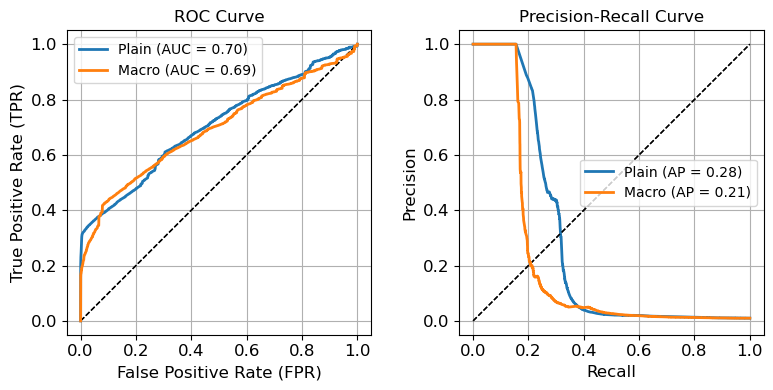

,Plain,Macro
Precision,0.04,0.18
Recall,0.39,0.22
F1,0.08,0.20
Average Precision,0.28,0.21
ROC-AUC,0.70,0.69


In [529]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# ROC curve
plot_roc_curve(metrics_nomacro['roc_curve'], metrics_nomacro['roc_auc_score'], color='C0', ax=ax[0], legend='Plain')
plot_roc_curve(metrics_macro['roc_curve'], metrics_macro['roc_auc_score'], color='C1', ax=ax[0], legend='Macro')
# PR curve
plot_precision_recall_curve(metrics_nomacro['precision_recall_curve'], metrics_nomacro['ap_score'], color='C0', ax=ax[1], legend='Plain')
plot_precision_recall_curve(metrics_macro['precision_recall_curve'], metrics_macro['ap_score'], color='C1', ax=ax[1], legend='Macro')

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

# plt.savefig(fig_folder+'roc_pr_curve.png', dpi=300)
plt.show()

models_metrics=[]
models_metrics.append([metrics_nomacro['precision_score'], 
                       metrics_nomacro['recall_score'], 
                       metrics_nomacro['f1_score'], 
                       metrics_nomacro['ap_score'],
                       metrics_nomacro['roc_auc_score']])
models_metrics.append([metrics_macro['precision_score'], 
                       metrics_macro['recall_score'], 
                       metrics_macro['f1_score'], 
                       metrics_macro['ap_score'],
                       metrics_macro['roc_auc_score']])

display(pd.DataFrame(models_metrics, columns=['Precision', 'Recall', 'F1', 'Average Precision', 'ROC-AUC'], 
                     index=['Plain', 'Macro']).round(2).T)

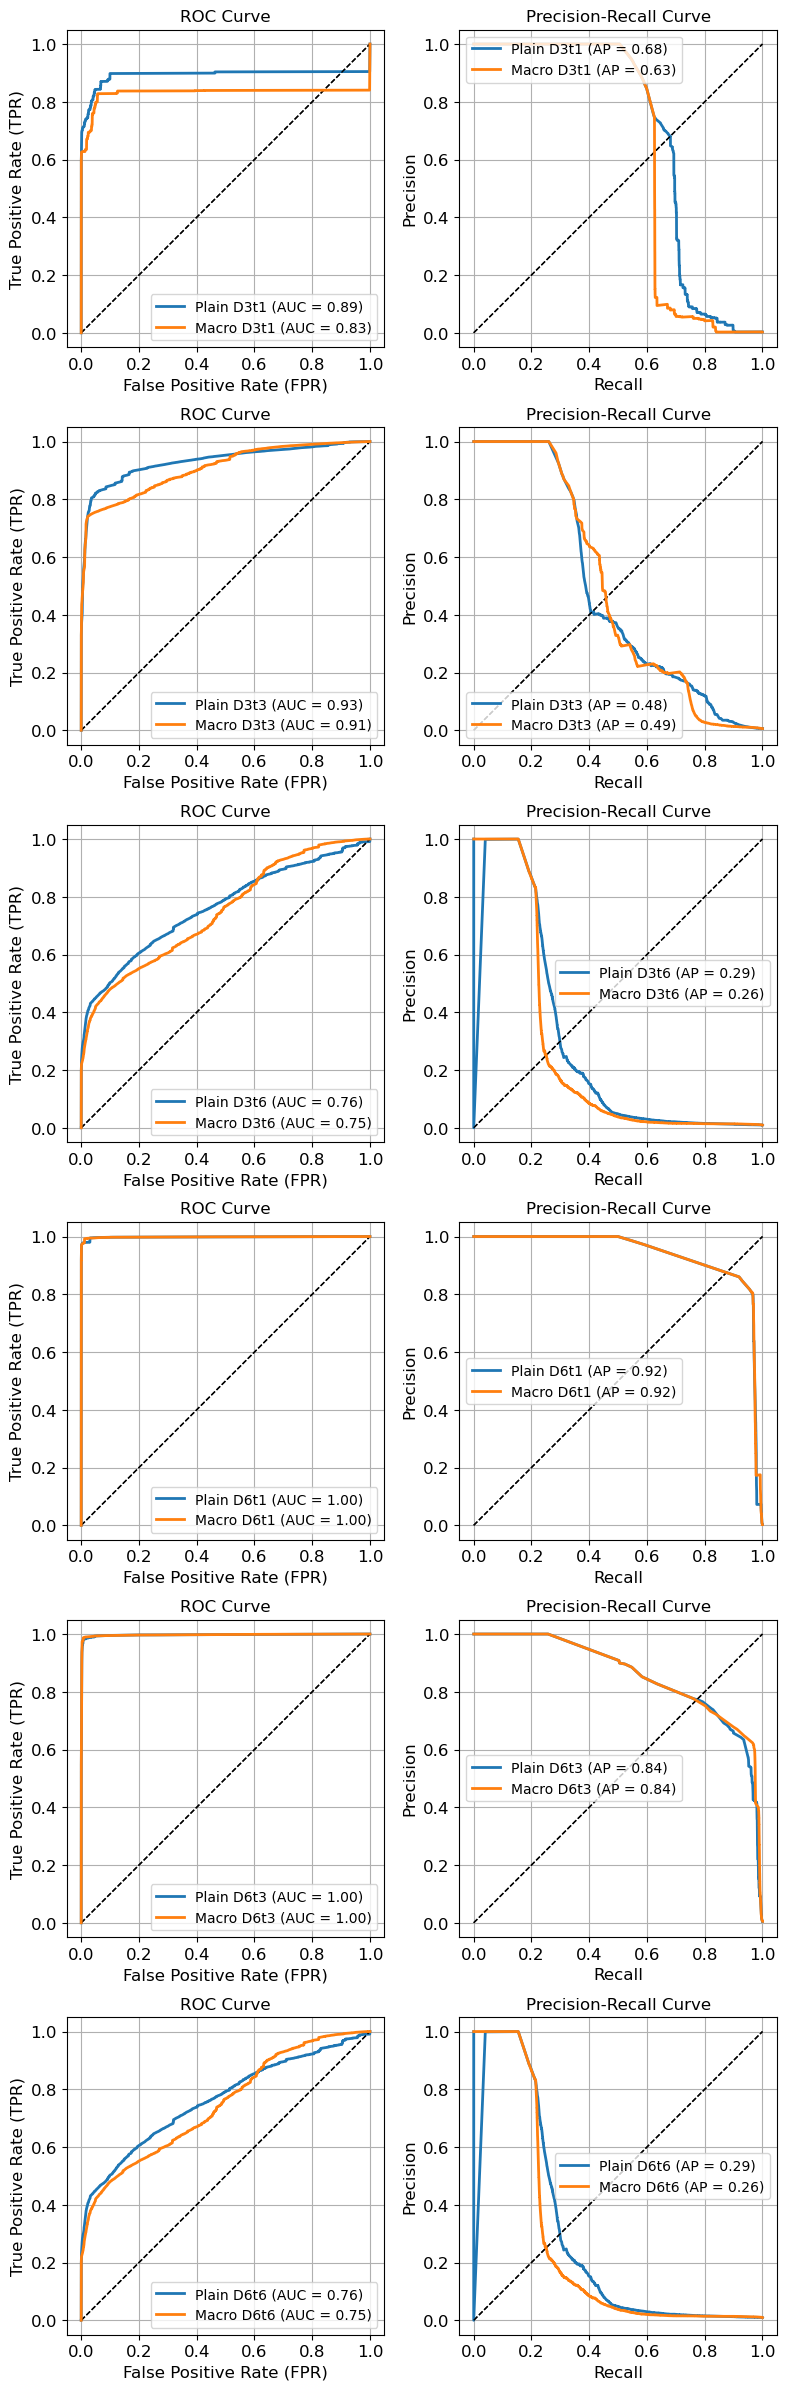

,Plain D3t1,Macro D3t1,Plain D3t3,Macro D3t3,Plain D3t6,Macro D3t6,Plain D6t1,Macro D6t1,Plain D6t3,Macro D6t3,Plain D6t6,Macro D6t6
Precision,0.55,0.64,0.23,0.47,0.07,0.17,0.28,0.50,0.36,0.39,0.07,0.17
Recall,0.69,0.63,0.60,0.46,0.46,0.30,0.98,0.97,0.98,0.99,0.46,0.30
F1,0.61,0.63,0.33,0.47,0.13,0.21,0.43,0.66,0.53,0.56,0.13,0.21
Average Precision,0.68,0.63,0.48,0.49,0.29,0.26,0.92,0.92,0.84,0.84,0.29,0.26
ROC-AUC,0.89,0.83,0.93,0.91,0.76,0.75,1.00,1.00,1.00,1.00,0.76,0.75


In [47]:
fig, ax = plt.subplots(6, 2, figsize=(8, 24))

models_metrics=[]
for i, k in enumerate(metrics_macro.keys()):
    # ROC curve
    plot_roc_curve(metrics_nomacro[k]['roc_curve'], metrics_nomacro[k]['roc_auc_score'], 
                   color='C0', ax=ax[i, 0], legend=f'Plain {k}')
    plot_roc_curve(metrics_macro[k]['roc_curve'], metrics_macro[k]['roc_auc_score'], 
                   color='C1', ax=ax[i, 0], legend=f'Macro {k}')
    # PR curve
    plot_precision_recall_curve(metrics_nomacro[k]['precision_recall_curve'], metrics_nomacro[k]['ap_score'], 
                                color='C0', ax=ax[i, 1], legend=f'Plain {k}')
    plot_precision_recall_curve(metrics_macro[k]['precision_recall_curve'], metrics_macro[k]['ap_score'], 
                                color='C1', ax=ax[i, 1], legend=f'Macro {k}')

    ax[i, 0].set_aspect('equal')
    ax[i, 1].set_aspect('equal')

    models_metrics.append([metrics_nomacro[k]['precision_score'], 
                           metrics_nomacro[k]['recall_score'], 
                           metrics_nomacro[k]['f1_score'], 
                           metrics_nomacro[k]['ap_score'],
                           metrics_nomacro[k]['roc_auc_score']])
    models_metrics.append([metrics_macro[k]['precision_score'], 
                           metrics_macro[k]['recall_score'], 
                           metrics_macro[k]['f1_score'], 
                           metrics_macro[k]['ap_score'],
                           metrics_macro[k]['roc_auc_score']])



# plt.savefig(fig_folder+'roc_pr_curve.png', dpi=300)
plt.show()




display(pd.DataFrame(models_metrics, columns=['Precision', 'Recall', 'F1', 'Average Precision', 'ROC-AUC'], 
                     index=np.array([[f'Plain {i}', f'Macro {i}'] for i in list(metrics_macro.keys())]).reshape(12)).round(2).T)

In [48]:
list(metrics_macro.keys()

dict_keys(['D3t1', 'D3t3', 'D3t6', 'D6t1', 'D6t3', 'D6t6'])

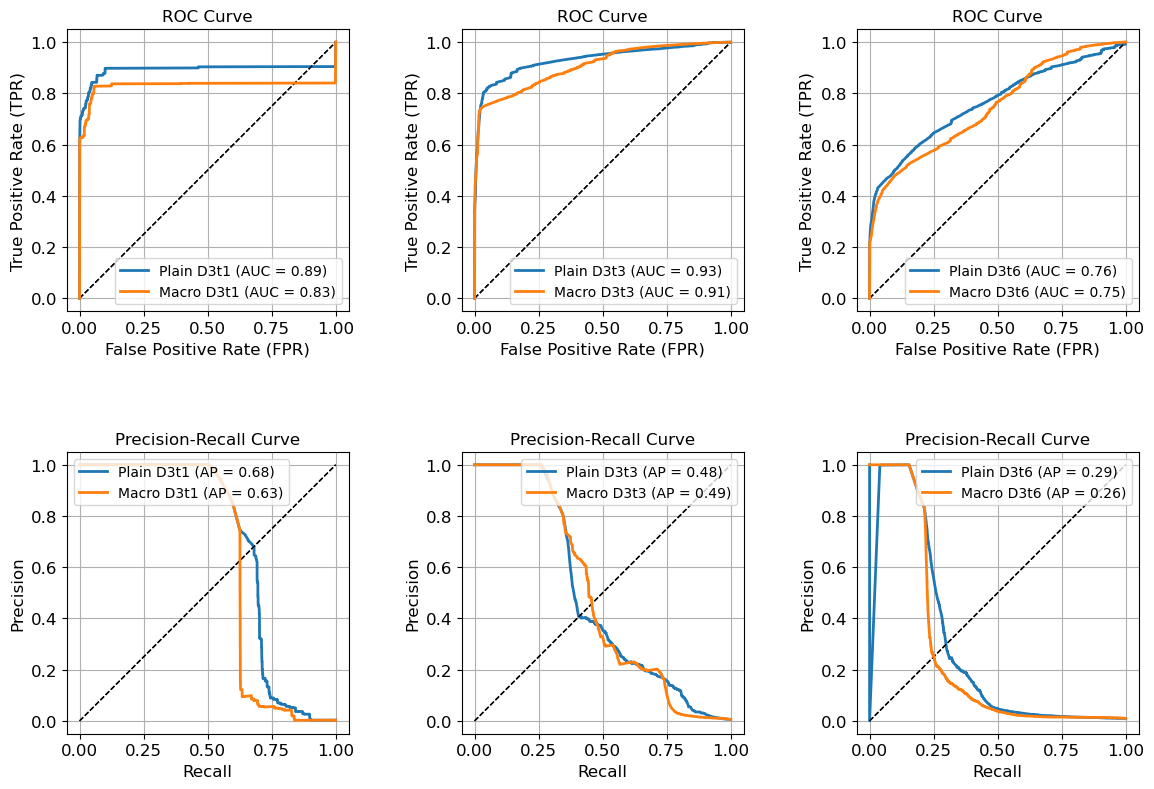

,Plain D3t1,Macro D3t1,Plain D3t3,Macro D3t3,Plain D3t6,Macro D3t6
Precision,0.55,0.64,0.23,0.47,0.07,0.17
Recall,0.69,0.63,0.60,0.46,0.46,0.30
F1,0.61,0.63,0.33,0.47,0.13,0.21
Average Precision,0.68,0.63,0.48,0.49,0.29,0.26
ROC-AUC,0.89,0.83,0.93,0.91,0.76,0.75


In [53]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

models_metrics=[]
dataset_list = ['D3t1', 'D3t3', 'D3t6']
for i, k in enumerate(dataset_list):
    # ROC curve
    plot_roc_curve(metrics_nomacro[k]['roc_curve'], metrics_nomacro[k]['roc_auc_score'], 
                   color='C0', ax=ax[0, i], legend=f'Plain {k}')
    plot_roc_curve(metrics_macro[k]['roc_curve'], metrics_macro[k]['roc_auc_score'], 
                   color='C1', ax=ax[0, i], legend=f'Macro {k}')
    # PR curve
    plot_precision_recall_curve(metrics_nomacro[k]['precision_recall_curve'], metrics_nomacro[k]['ap_score'], 
                                color='C0', ax=ax[1, i], legend=f'Plain {k}')
    plot_precision_recall_curve(metrics_macro[k]['precision_recall_curve'], metrics_macro[k]['ap_score'], 
                                color='C1', ax=ax[1, i], legend=f'Macro {k}')

    ax[0, i].set_aspect('equal')
    ax[1, i].set_aspect('equal')

    models_metrics.append([metrics_nomacro[k]['precision_score'], 
                           metrics_nomacro[k]['recall_score'], 
                           metrics_nomacro[k]['f1_score'], 
                           metrics_nomacro[k]['ap_score'],
                           metrics_nomacro[k]['roc_auc_score']])
    models_metrics.append([metrics_macro[k]['precision_score'], 
                           metrics_macro[k]['recall_score'], 
                           metrics_macro[k]['f1_score'], 
                           metrics_macro[k]['ap_score'],
                           metrics_macro[k]['roc_auc_score']])



# plt.savefig(fig_folder+'roc_pr_curve.png', dpi=300)
plt.subplots_adjust(hspace=0.5)
plt.show()




display(pd.DataFrame(models_metrics, columns=['Precision', 'Recall', 'F1', 'Average Precision', 'ROC-AUC'], 
                     index=np.array([[f'Plain {i}', f'Macro {i}'] for i in dataset_list]).reshape(6)).round(2).T)

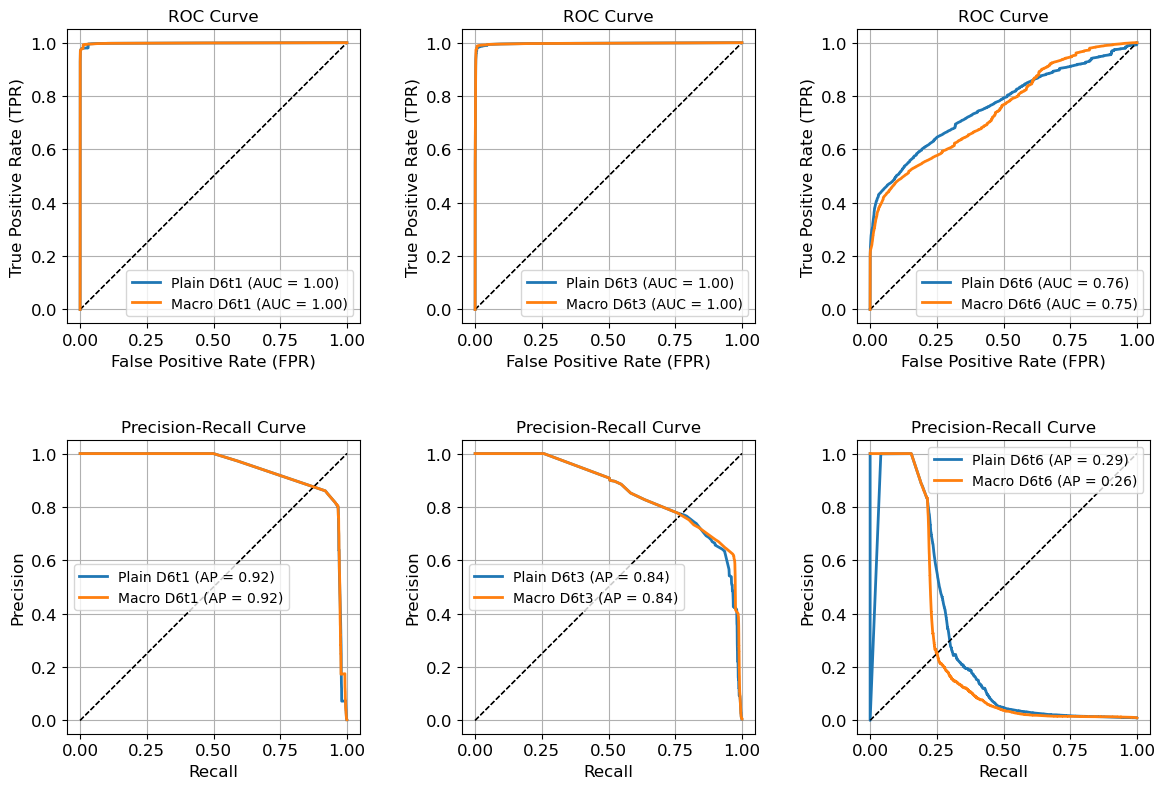

,Plain D6t1,Macro D6t1,Plain D6t3,Macro D6t3,Plain D6t6,Macro D6t6
Precision,0.28,0.50,0.36,0.39,0.07,0.17
Recall,0.98,0.97,0.98,0.99,0.46,0.30
F1,0.43,0.66,0.53,0.56,0.13,0.21
Average Precision,0.92,0.92,0.84,0.84,0.29,0.26
ROC-AUC,1.00,1.00,1.00,1.00,0.76,0.75


In [55]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

models_metrics=[]
dataset_list = ['D6t1', 'D6t3', 'D6t6']
for i, k in enumerate(dataset_list):
    # ROC curve
    plot_roc_curve(metrics_nomacro[k]['roc_curve'], metrics_nomacro[k]['roc_auc_score'], 
                   color='C0', ax=ax[0, i], legend=f'Plain {k}')
    plot_roc_curve(metrics_macro[k]['roc_curve'], metrics_macro[k]['roc_auc_score'], 
                   color='C1', ax=ax[0, i], legend=f'Macro {k}')
    # PR curve
    plot_precision_recall_curve(metrics_nomacro[k]['precision_recall_curve'], metrics_nomacro[k]['ap_score'], 
                                color='C0', ax=ax[1, i], legend=f'Plain {k}')
    plot_precision_recall_curve(metrics_macro[k]['precision_recall_curve'], metrics_macro[k]['ap_score'], 
                                color='C1', ax=ax[1, i], legend=f'Macro {k}')

    ax[0, i].set_aspect('equal')
    ax[1, i].set_aspect('equal')

    models_metrics.append([metrics_nomacro[k]['precision_score'], 
                           metrics_nomacro[k]['recall_score'], 
                           metrics_nomacro[k]['f1_score'], 
                           metrics_nomacro[k]['ap_score'],
                           metrics_nomacro[k]['roc_auc_score']])
    models_metrics.append([metrics_macro[k]['precision_score'], 
                           metrics_macro[k]['recall_score'], 
                           metrics_macro[k]['f1_score'], 
                           metrics_macro[k]['ap_score'],
                           metrics_macro[k]['roc_auc_score']])



# plt.savefig(fig_folder+'roc_pr_curve.png', dpi=300)
plt.subplots_adjust(hspace=0.4)
plt.show()




display(pd.DataFrame(models_metrics, columns=['Precision', 'Recall', 'F1', 'Average Precision', 'ROC-AUC'], 
                     index=np.array([[f'Plain {i}', f'Macro {i}'] for i in dataset_list]).reshape(6)).round(2).T)

### SHAP

In [561]:
%%time
# Create SHAP Explainer for model
explainer_macro = shap.Explainer(xgbm_macro, X_train_macro)
# Calculate SHAP values
shap_values_macro = explainer(X_test_macro)

NameError: name 'shap' is not defined

<font size=3> Evaluation Functions </font>

In [32]:
def evaluate_model(model, dtest, y_test, threshold=0.5):
    ''' Evaluate the model and return metrics obtained. '''
    
    # Predictions
    pred_prob = model.predict(dtest)
    pred = (pred_prob >= threshold).astype(int)
    
    # Metrics
    metrics = {
        'recall_score': recall_score(y_test, pred),
        'precision_score': precision_score(y_test, pred),
        'f1_score': f1_score(y_test, pred),
        'ap_score': average_precision_score(y_test, pred_prob),
        'precision_recall_curve': precision_recall_curve(y_test, pred_prob),
        'roc_auc_score': roc_auc_score(y_test, pred_prob),
        'roc_curve': roc_curve(y_test, pred_prob)
    }

    return metrics

In [33]:
# --- Precision recall curve ---
def plot_precision_recall_curve(model_pr_curve, average_precision, color='C0', legend=None, 
                                lw=2, ls='-', marker=None, ax=None, 
                                title_fs=12, axis_label_fs=12, legend_fs=10, axis_tick_fs=12):
    ''' Plot the precision-recall curve.'''
    # Compute the precision, recall and threshold
    precision, recall, thresholds = model_pr_curve
    
    # fig, ax = plt.subplots(figsize=(4.5, 4))
    if ax is None:
        ax = plt.gca()
    
    # Plot the curve
    ax.plot([0, 1], [0, 1], color='k', linestyle='--', lw=1)  # Plot the diagonal line (random classifier)
    label=[f'{legend} (AP = {average_precision:.2f})' if legend else f'(AP = {average_precision:.2f})']
    ax.plot(recall, precision, color=color, marker=marker, lw=lw, ls=ls, label=label)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('Recall', fontsize=axis_label_fs)
    ax.set_ylabel('Precision', fontsize=axis_label_fs)
    ax.set_title('Precision-Recall Curve', fontsize=title_fs)
    ax.legend(loc='best', fontsize=legend_fs)
    ax.tick_params(labelsize=axis_tick_fs)
    ax.grid(True)

    plt.tight_layout()
    # plt.show()
    # plt.savefig('precision_recall_curve.png', dpi=500, bbox_inches='tight')

In [34]:
# Plot the ROC curve
def plot_roc_curve(model_roc_curve, roc_auc, color='C0', legend=None, ax=None, 
                   lw=2, ls='-', title_fs=12, axis_label_fs=12, legend_fs=10, axis_tick_fs=12):
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = model_roc_curve

    # fig, ax = plt.subplots(figsize=(4.5, 4))
    if ax is None:
        ax = plt.gca()

    ax.plot([0, 1], [0, 1], color='k', linestyle='--', lw=1)  # Plot the diagonal line (random classifier)
    label=[f'{legend} (AUC = {roc_auc:.2f})' if legend else f'(AUC = {roc_auc:.2f})']
    ax.plot(fpr, tpr, color=color, lw=lw, ls=ls, label=label)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate (FPR)', fontsize=axis_label_fs)
    ax.set_ylabel('True Positive Rate (TPR)', fontsize=axis_label_fs)
    ax.set_title('ROC Curve', fontsize=title_fs)
    ax.legend(loc='best', fontsize=legend_fs)
    ax.tick_params(labelsize=axis_tick_fs)
    ax.grid(True)
    # plt.show()


Features:

- Credit score
- Income
- Demographics/Geography (aggregate features)


Macroeconomics

- GDP
- Unemployment rate
- Interest rates
- 

<font size=5> Archive </font>

In [332]:
# # GDP
# def load_BEA_GDP(path, filename, to_monthly_method=None):
#     gdp = pd.read_csv(path+filename, skiprows=3)
#     gdp.drop('Line', axis=1, inplace=True)
#     gdp.rename(columns={'Unnamed: 1': 'Measure'}, inplace=True)
#     gdp.loc[0, 'Measure'] = 'quarter'
#     gdp = gdp.T
#     gdp.columns = gdp.iloc[0].to_list()
#     gdp.drop(gdp.index[0], inplace=True)
#     gdp.reset_index(inplace=True)
#     gdp.rename(columns={'index':'year', '        Gross domestic product':'gdp_quarter'}, inplace=True)
#     gdp.insert(0, 'time', gdp['year'].str[:4]+gdp['quarter'])
#     gdp['gdp_quarter'] = gdp['gdp_quarter'].astype(float)
#     gdp['time'] = pd.PeriodIndex(gdp['time'], freq='Q').to_timestamp()
#     gdp = gdp[['time', 'gdp_quarter']]
    
#     if to_monthly_method == 'repeat':
#         return gdp.set_index('time').resample('MS').ffill().rename(columns={'gdp_quarter':'gdp'}).reset_index()
#     elif to_monthly_method == 'interpolate':
#         return gdp.set_index('time').resample('MS').interpolate(method="linear").rename(columns={'gdp_quarter':'gdp'}).reset_index()
#     else:
#         return gdp.rename(columns={'gdp_quarter':'gdp'})

# gdp = load_BEA_GDP(DATA_PATH+'macro/', 'BEA_GDP_2005_to_2024.csv', to_monthly_method='interpolate')

In [226]:
# def define_default(df: pd.DataFrame, delinquency_threshold: int=None, pred_tw: int=None) -> pd.DataFrame:

#     # # Target default time window must be less then default threshold
#     # if pred_tw >= delinquency_threshold:
#     #     raise ValueError('pred_tw must be < delinquency_threshold.')
    
#     # Step 1: Identify the first month each loan defaults (delinquency_status >= 6)
#     df['default_flag'] = ((df['delinquency_status'] >= delinquency_threshold) | (df['zero_balance_code'].isin([3, 9, 15])))

#     # Step 2: Separate default from non-default loans
#     default_loans = df.loc[df['default_flag'] == True]['loan_identifier'].unique()
#     df_non_default_loans = df[~df['loan_identifier'].isin(default_loans)]
#     df = df.loc[df['loan_identifier'].isin(default_loans)]

#     # Step 3: Find the first default month per loan
#     first_default_time = df[df['default_flag']].groupby('loan_identifier')['time'].min().rename('default_time')

#     # Step 4: Merge this info back to the main dataframe
#     df = df.merge(first_default_time, on='loan_identifier', how='left')
#     df['default_time'] = df['default_time'].fillna(pd.NaT)

#     # Step 5: Create an irreversible default flag (1 if loan has defaulted, 0 otherwise)
#     df['default'] = (df['time'] >= df['default_time']).astype(int)

#     # Step 6: Keep only records **before** or **at** the first default event
#     df = df[df['time'] <= df['default_time']].copy()

#     # Step 7: Create a target variable for PD (whether the loan will default in the next N month time window – pred_tw)
#     df['pd_target'] = df.groupby('loan_identifier')['default_flag'].shift(-pred_tw).astype(float).ffill()
#     df.loc[df['time'] >= df['default_time'], 'pd_target'] = 1 # Default before pred_tw
#     df['pd_target'] = df['pd_target'].fillna(0).astype(int) # Not default before pred_tw

#     # Step 8: Append non-default loans
#     df = pd.concat([df, df_non_default_loans])
#     df['default'] = df['default'].fillna(0)
#     df['pd_target'] = df['pd_target'].fillna(0)

#     df.drop(['default_flag', 'default_time'], axis=1, inplace=True)
#     df.sort_values('time', inplace=True)
#     df.reset_index(drop=True, inplace=True)

#     return df